In [2]:
%load_ext autoreload
%autoreload 2

In [140]:
import shap
from sklearn import datasets
from sklearn.metrics import roc_auc_score
import numbers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, r2_score
import seaborn as sns
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import verify_shap_model, smooth_shap, GridSearchCV_scratch, cross_val_score_scratch
from TreeModelsFromScratch.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION, DATASET_PATH
from imodels.util.data_util import get_clean_dataset
import os
from datetime import datetime
import pickle
from tqdm import tqdm, trange
from sklearn.datasets import make_friedman1
from matplotlib.cm import ScalarMappable

# Nodewise shrinkage 

## Friedman 1

`Friedman1` (also referred as `MARS` simulation) [source] was also used as one of the benchmark datasets in the HS paper []. <br>
- HS paper calls a function which is implemented in imodels [`get_clean_dataset` function](https://github.com/csinva/imodels/blob/3c6ebbd4868711efaf237da99711dea747124aba/imodels/util/data_util.py#L119) to create the so called "friedman1" dataset
- The imodels function however just calls the sklearn `make_friedman1` [function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html)

**Definition from sklearn**<br>
Inputs `X` are independent features uniformly distributed on the interval [0, 1]. The output `y` is created according to the formula: <br>
`y(X) = 10 * sin(pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4] + noise * N(0, 1)`
<br>
Out of the `n_features` features, only 5 are actually used to compute `y`. The remaining features are independent of `y`.

- Friedman, Grosse ans Stuetzle (1983) originally created this function to uncover interaction effects that are present in data. In the original setting they used `n_samples=200` and `n_features=6` (one noisy feature)
- Mentch (2020) used the same function in his paper (source), but in a more difficult setting. They reduced the `n_samples=100` and increased the `n_features=10` so that there are 5 noise features independent of f(x)
- The HS paper used the same function with `n_samples=200` and `n_features=10`

For this thesis, we will also use the syntetic dataset with the same parameter settings as in the HS paper: `n_samples=200` and `n_features=10` <br>
A lower sample size of 100 (as in simulation by Mentch) should "only" increase variability within the results?

### Load data and train model

In [ ]:
#load data
X, y = make_friedman1(n_samples=200, n_features=10, noise=0.0, random_state=None)

Based on results from the performance simulations we do not need to perform a GridSearch for the best lambda but will set lambda to 0.1

In [25]:
# Train RF model 
rf = RandomForest(n_trees=100, treetype="regression", HShrinkage=False, HS_lambda=0.1, HS_nodewise_shrink_type="MSE_ratio")
rf.fit(X, y)

### Create dataframe for plotting

In [26]:
# add m_value to node_dict
for tree in rf.trees:
    for node_id in range(tree.n_nodes):
        tree.node_id_dict[node_id]["m_value"] = tree.nodewise_HS_dict.get("m_values")[node_id]

In [4]:
# Little helper function to find parend node id
def find_parent_node_id(tree, child_id):
    for path in tree.decision_paths:
        if child_id ==0:
            return -1 #set -1 for root node
        elif child_id in path:
            return path[path.index(child_id)-1]


In [27]:
# Create dataframe for each tree and concat for plotting
dfs=[]

for i, tree in enumerate(rf.trees):
    
    # create dataframe out of tree node_id_dict
    df = pd.DataFrame.from_dict(tree.node_id_dict).T[['id', 'depth', "feature", 'samples', 'm_value']]
    df["tree_id"]=i
    df.rename(columns={"id":"node_id", "depth":"node_depth", "feature":"child_feature"}, inplace=True)
    df = df.astype({'node_id': int, "node_depth": int, "samples": int, "m_value": float})
    
    # # add columns regarding parent_node (not necessary)
    # df["parent_node_id"] = df.node_id.apply(lambda x: find_parent_node_id(tree, x))
    # df["parent_node_feature"] = df.parent_node_id.apply(lambda x: df.loc[x,"child_feature"] if x!=-1 else df.loc[0, "child_feature"])
    
    dfs.append(df)
    
df_plot = pd.concat(dfs, ignore_index=True)

### Create plot based on sample size

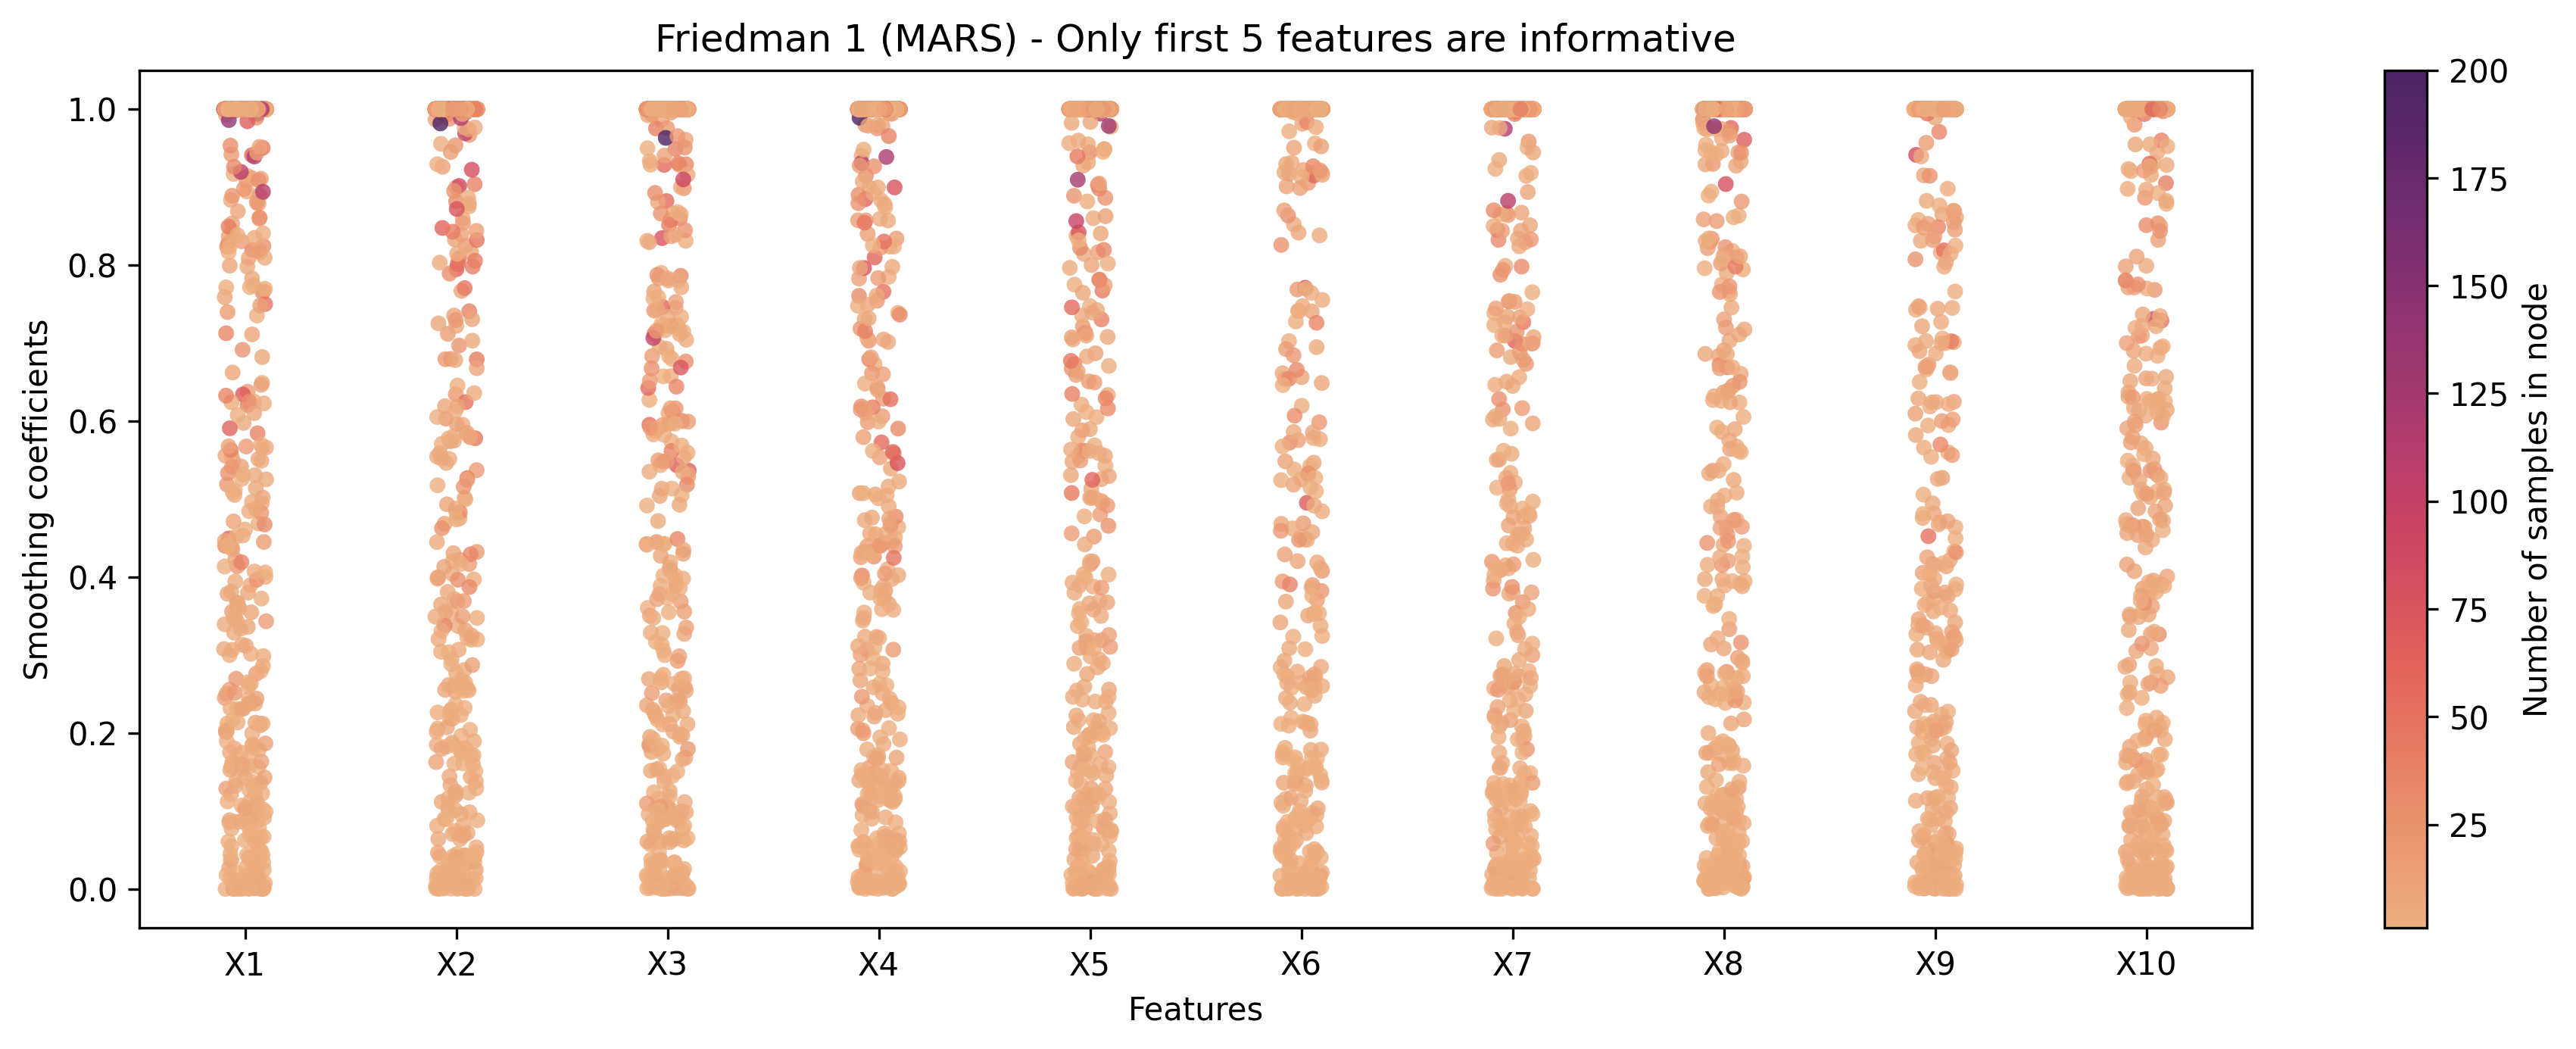

In [127]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=1, vmax=df_plot.samples.max()) 
palette = {h: cmap(norm(h)) for h in df_plot['samples']}

p = sns.stripplot(data=df_plot, x='child_feature', y='m_value', hue='samples', palette=palette, alpha=0.8, ax=axs)
p.legend_.remove()  # remove the categorical legend

axs.set_xticklabels([f"X{i}" for i in range(1,11)])
axs.set_title(f"Friedman 1 (MARS) - Only first 5 features are informative")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Number of samples in node")  # optionally add a colorbar
plt.show()

In [87]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","dis_smoothing_coefs")
filename = "friedman1_MSEratio_coef_dist_plot_sample_size"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

### Create plot based on node depth

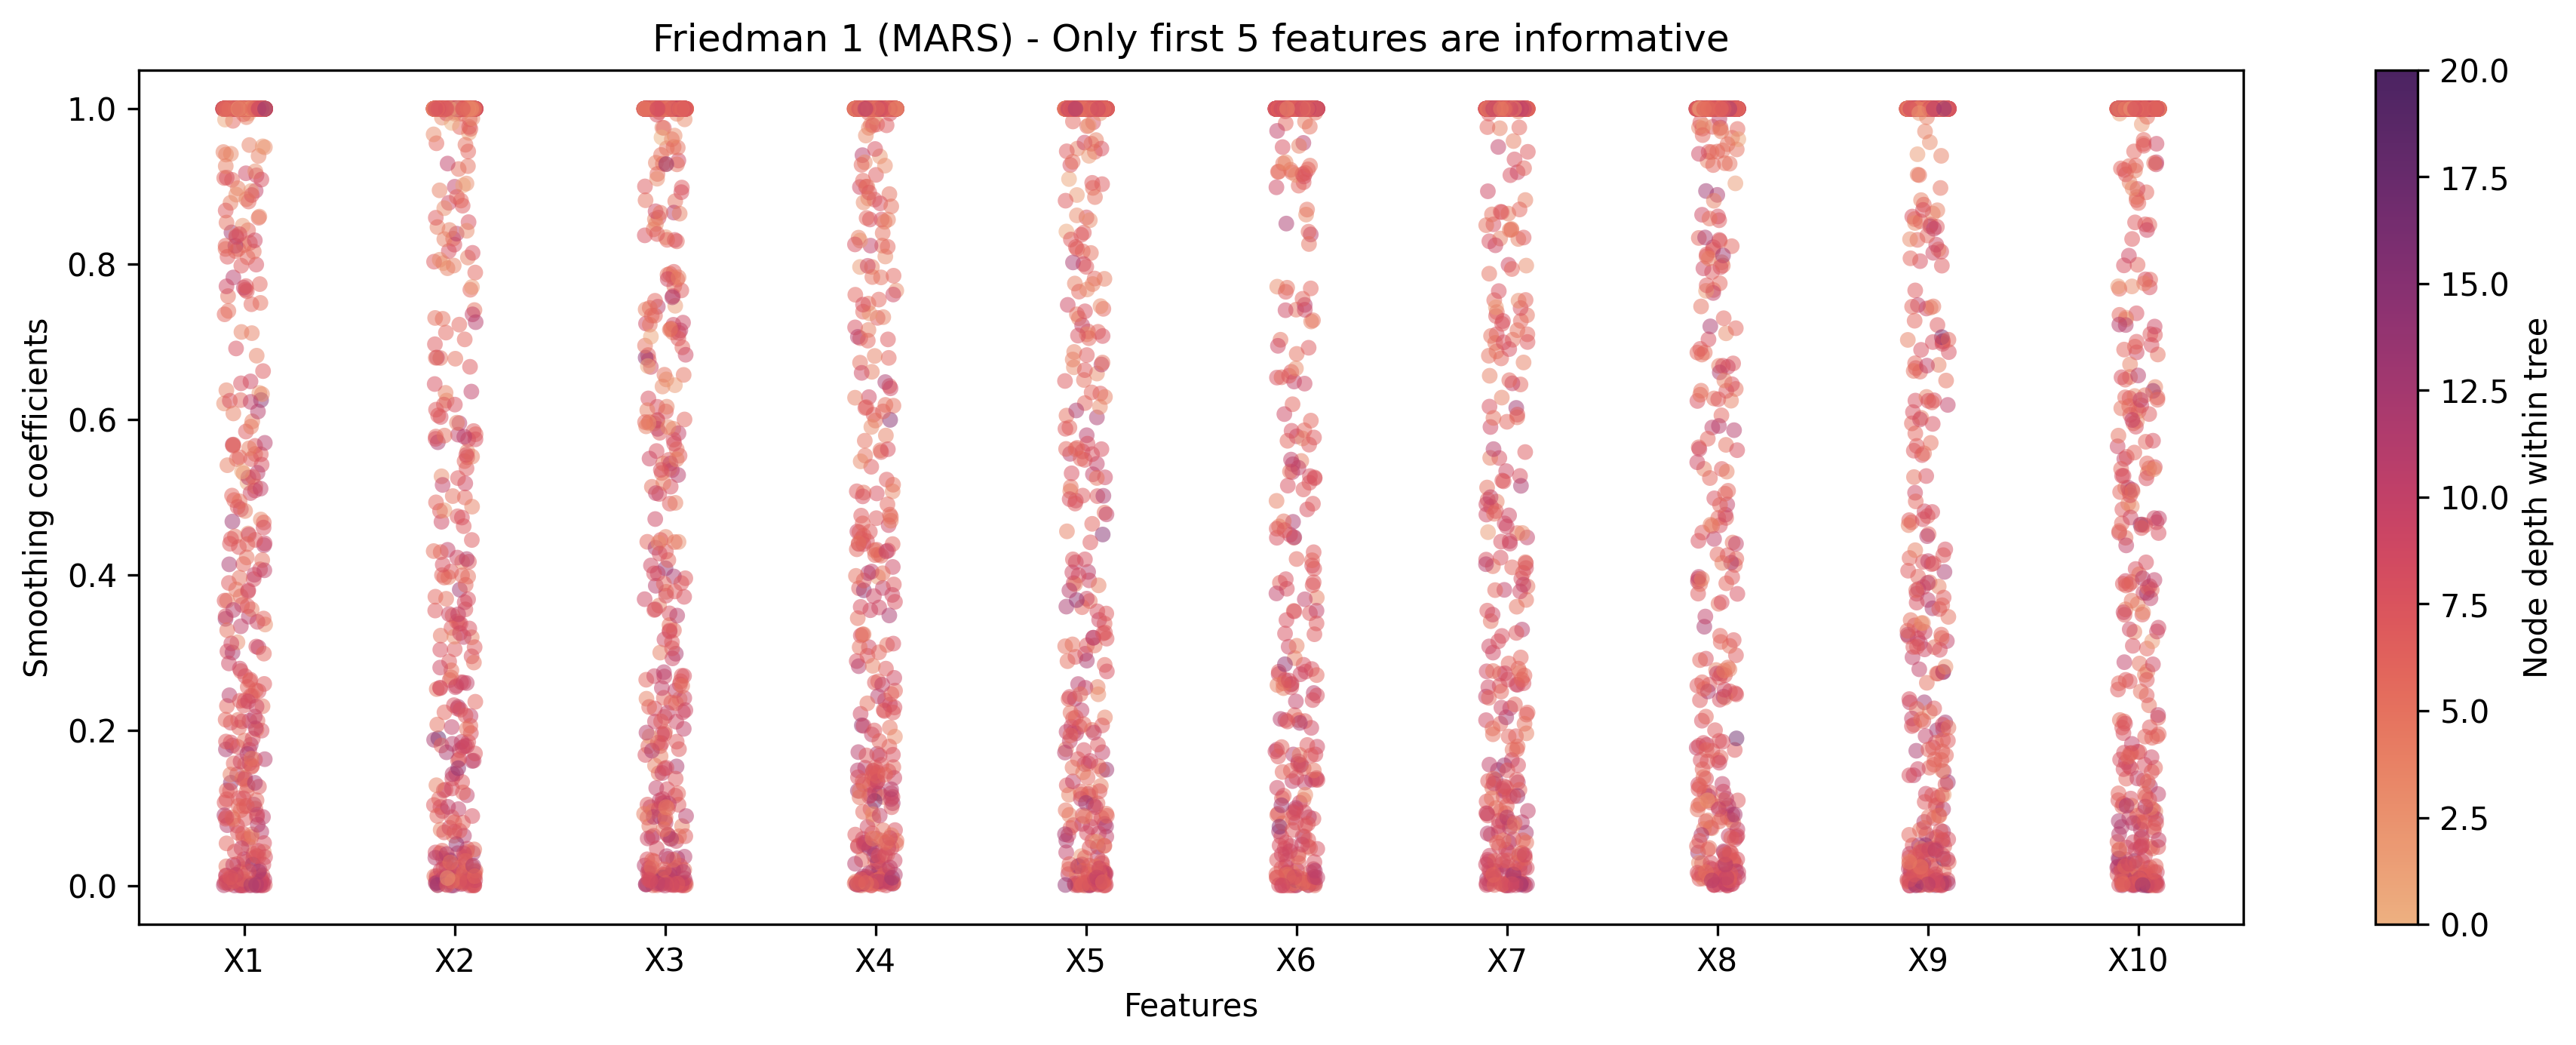

In [99]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=0, vmax=df_plot.node_depth.max()) 
palette = {h: cmap(norm(h)) for h in df_plot['node_depth']}

p = sns.stripplot(data=df_plot, x='child_feature', y='m_value', hue='node_depth', palette=palette, alpha=0.8, ax=axs)
p.legend_.remove()  # remove the categorical legend

axs.set_xticklabels([f"X{i}" for i in range(1,11)])
axs.set_title(f"Friedman 1 (MARS) - Only first 5 features are informative")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Node depth within tree")  # optionally add a colorbar
plt.show()

In [100]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","dis_smoothing_coefs")
filename = "friedman1_MSEratio_coef_dist_plot_node_depth"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

## Titanic

### Load data and train model

In [31]:
#Load and clean data
data = pd.read_csv("../raw_data/titanic/titanic_train.csv")
data = data[data["Age"].notnull()] #filter rows which are nan
data["Sex"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)
X_titanic = data[['Age', 'Pclass', 'Sex', 'PassengerId']]
y_titanic = data["Survived"].astype("float")

In [32]:
# Train RF model 
grid = {"HS_lambda":[0.1,1,5,10,25,50,100]}
rf_titanic = RandomForest(n_trees=100, treetype="classification", HShrinkage=False, HS_nodewise_shrink_type="MSE_ratio")
titanic_grid_cv = GridSearchCV_scratch(rf_titanic, grid, X_titanic, y_titanic, cv=3, scoring_func=roc_auc_score)
titanic_grid_cv.get("best_param_comb")

(50,)

Lambda=50 is the best hyperparameter setting according to 3 fold GridSearch

In [215]:
with open(f'{data_path}/titanic_MSEratio_model.pickle', 'wb') as handle:
    pickle.dump(rf_titanic, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Create df for plotting

In [33]:
# add m_value to node_dict
for tree in rf_titanic.trees:
    for node_id in range(tree.n_nodes):
        tree.node_id_dict[node_id]["m_value"] = tree.nodewise_HS_dict.get("m_values")[node_id]

In [34]:
# Create dataframe for each tree and concat for plotting
dfs_tit=[]

for i, tree in enumerate(rf_titanic.trees):
    
    # create dataframe out of tree node_id_dict
    df = pd.DataFrame.from_dict(tree.node_id_dict).T[['id', 'depth', "feature", 'samples', 'm_value']]
    df["tree_id"]=i
    df.rename(columns={"id":"node_id", "depth":"node_depth", "feature":"child_feature"}, inplace=True)
    df = df.astype({'node_id': int, "node_depth": int, "samples": int, "m_value": float})
    
    # # add columns regarding parent_node (not necessarry)
    # df["parent_node_id"] = df.node_id.apply(lambda x: find_parent_node_id(tree, x))
    # df["parent_node_feature"] = df.parent_node_id.apply(lambda x: df.loc[x,"child_feature"] if x!=-1 else df.loc[0, "child_feature"])
    # df["parent_node_samples"] = df.parent_node_id.apply(lambda x: df.loc[x,"samples"] if x!=-1 else df.loc[0, "samples"])
    
    dfs_tit.append(df)
    
df_plot_tit = pd.concat(dfs_tit, ignore_index=True)

### Create plot by sample size

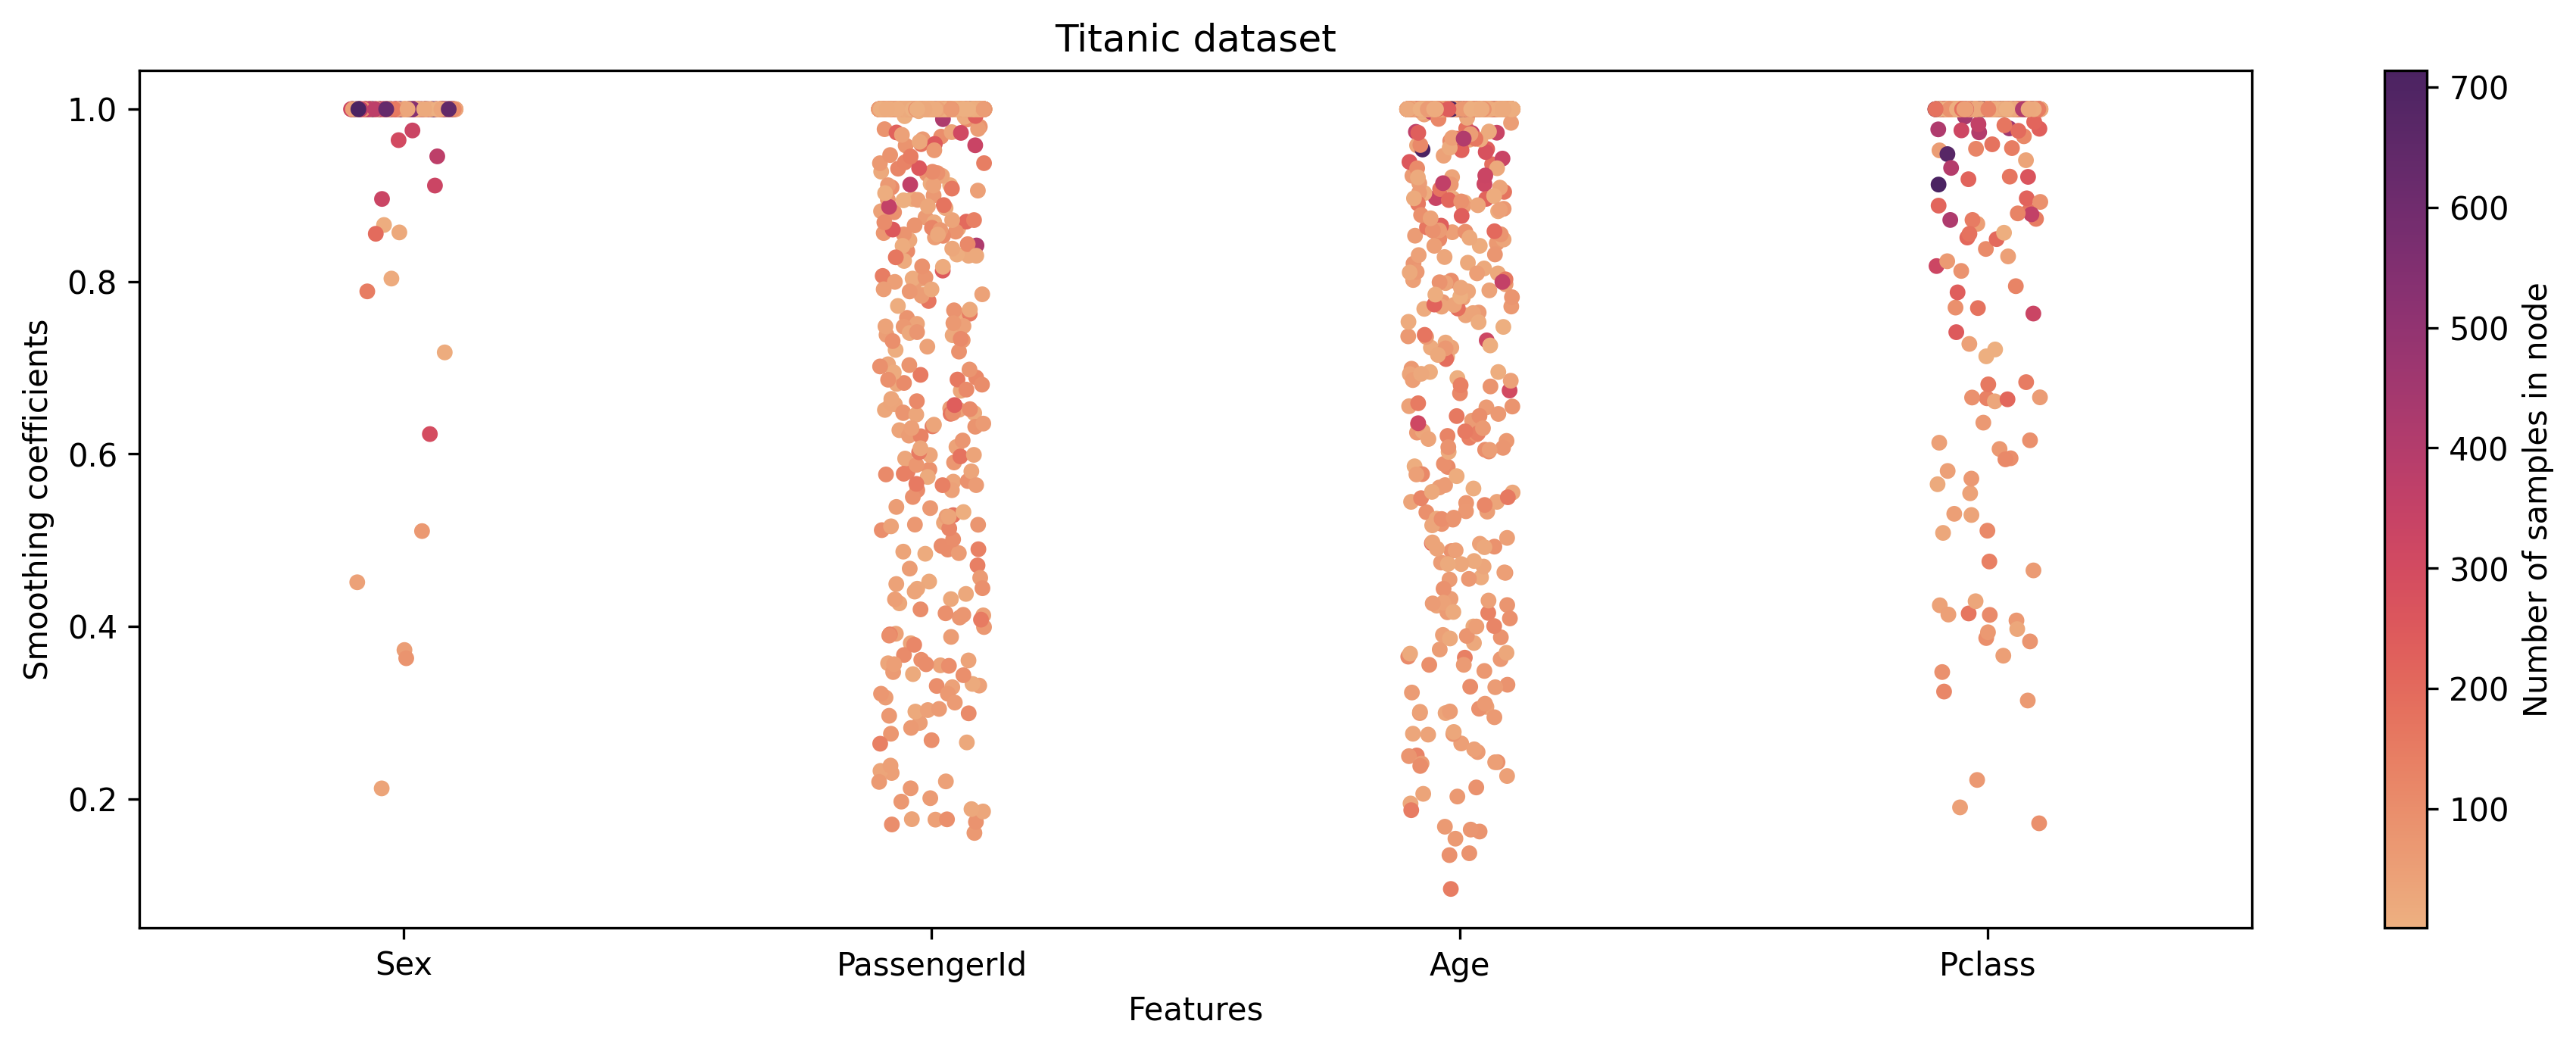

In [124]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=1, vmax=df_plot_tit.samples.max()) 
palette = {h: cmap(norm(h)) for h in df_plot_tit['samples']}

t = sns.stripplot(data=df_plot_tit, x='child_feature', y='m_value', hue='samples', palette=palette, alpha=1, ax=axs)
t.legend_.remove()  # remove the categorical legend

#axs.set_xticklabels([f"X{i}" for i in range(1,11)])
axs.set_title(f"Titanic dataset")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Number of samples in node")  # optionally add a colorbar
plt.show()

In [89]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_smoothing_coefs")
filename = "titanic_MSEratio_coef_dist_plot_sample_size"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

#### Analyze number of splits p. feature

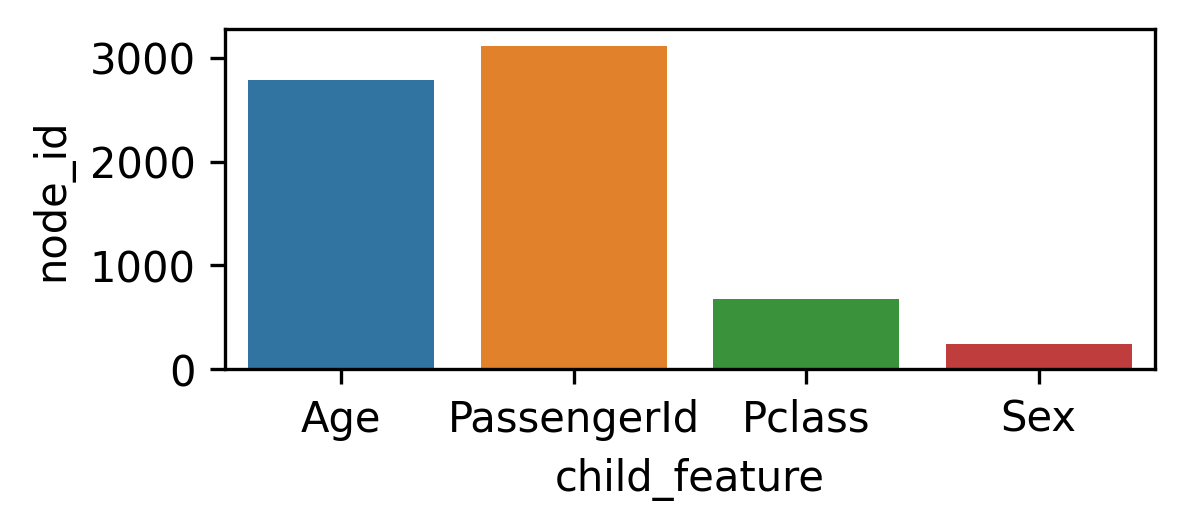

In [78]:
# examine how often a feature was used to split
fig, axs = plt.subplots(1,1,figsize=(4,1.5))
sns.barplot(ax=axs, data=df_plot_tit.groupby("child_feature").count()[["node_id"]].reset_index(), x="child_feature", y="node_id");

Features with high cardinalities are choosen more often as a split than features with low cardinality

### Create plot based on node depth in tree

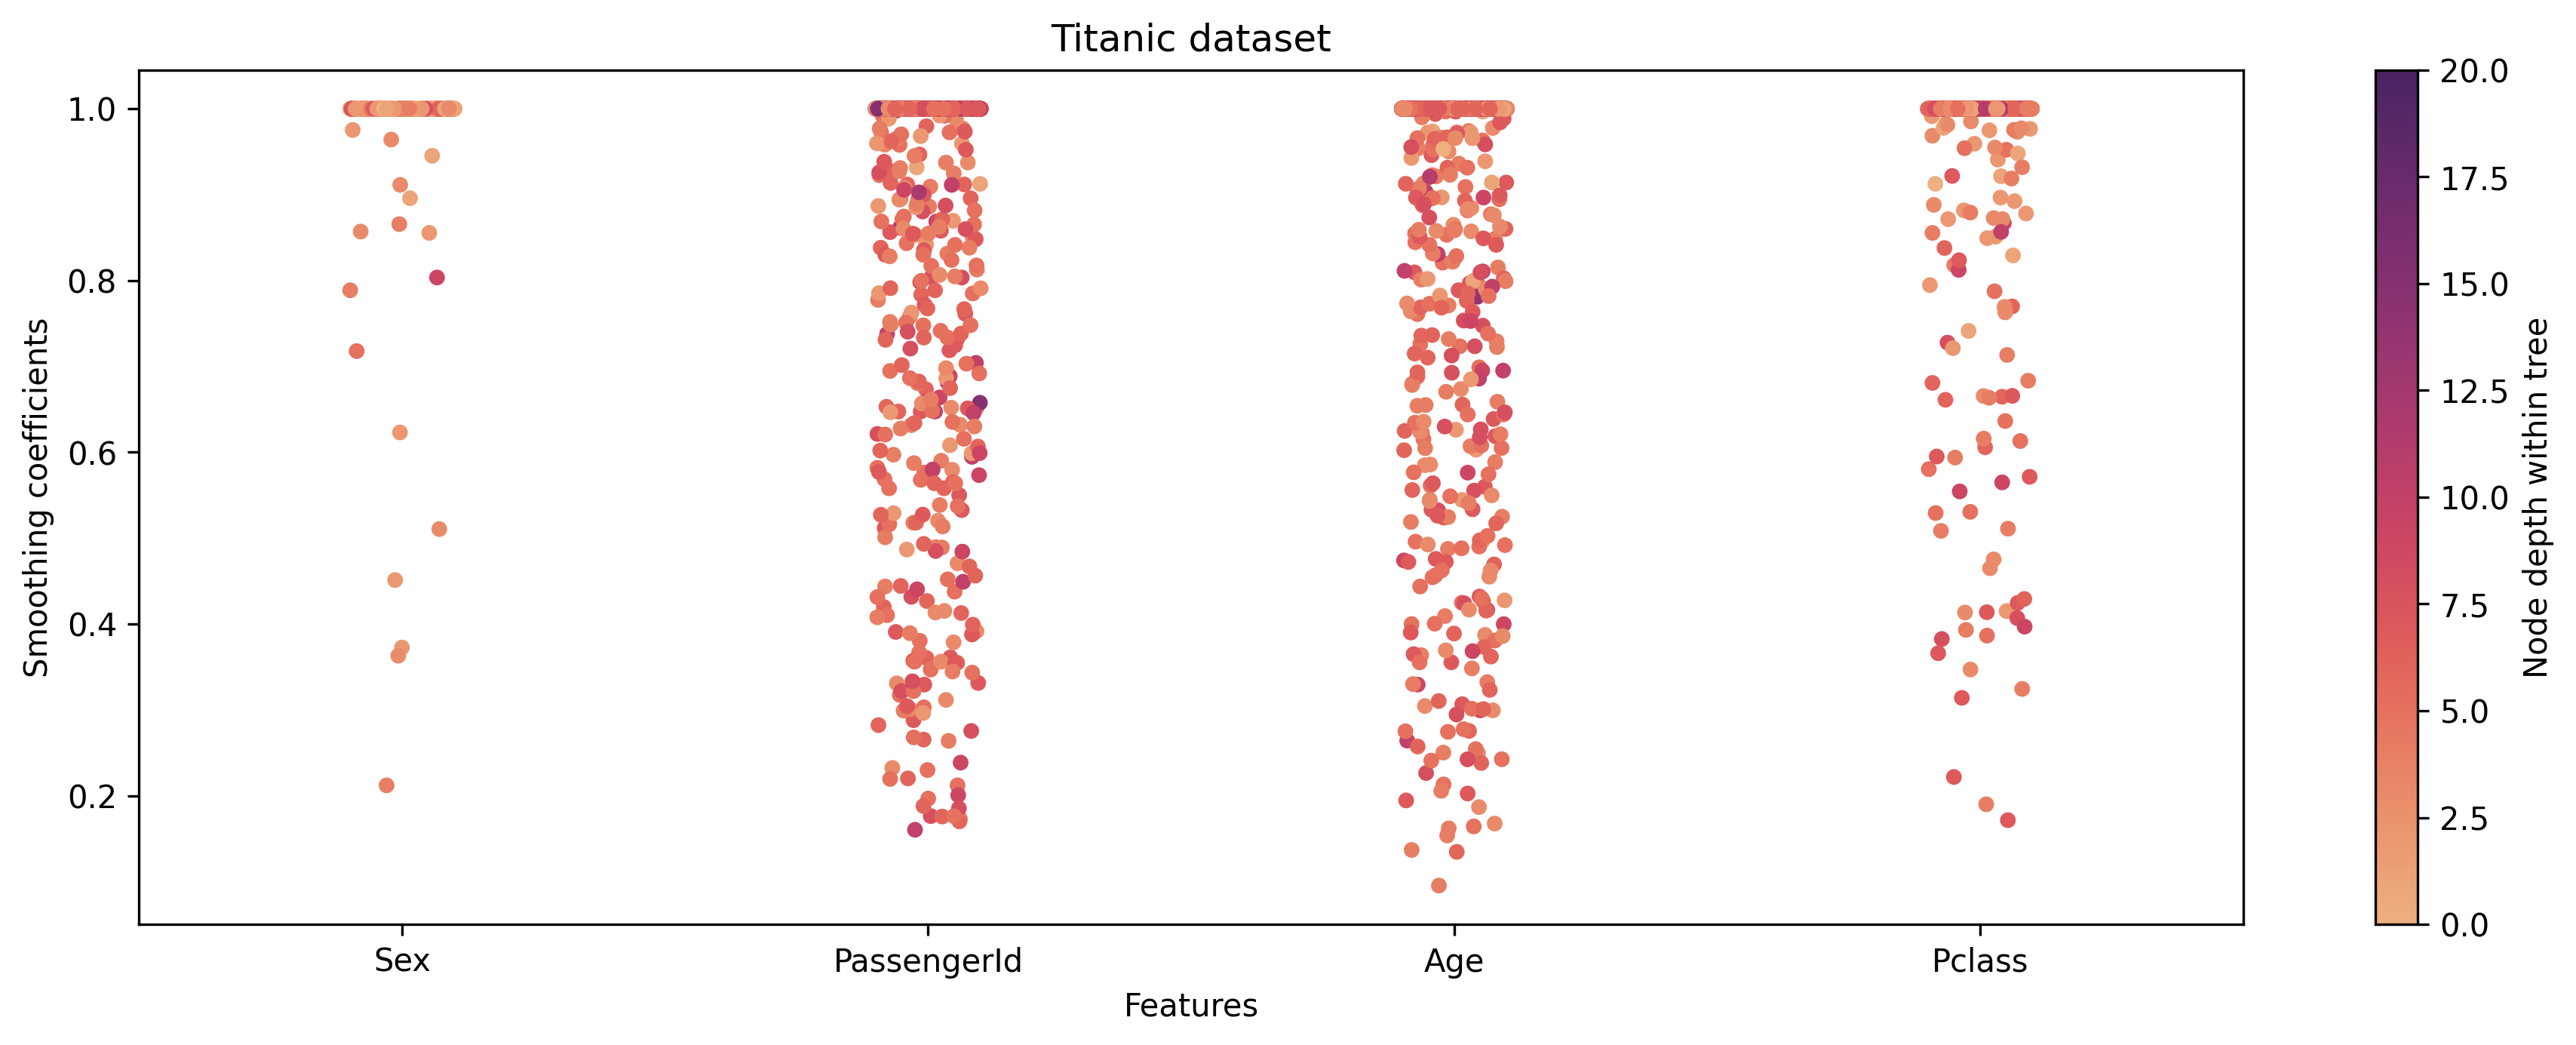

In [123]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=0, vmax=df_plot_tit.node_depth.max()) 
palette = {h: cmap(norm(h)) for h in df_plot_tit['node_depth']}

t = sns.stripplot(data=df_plot_tit, x='child_feature', y='m_value', hue='node_depth', palette=palette, alpha=1, ax=axs)
t.legend_.remove()  # remove the categorical legend

#axs.set_xticklabels([f"X{i}" for i in range(1,11)])
axs.set_title(f"Titanic dataset")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Node depth within tree")  # optionally add a colorbar
plt.show()

In [98]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_smoothing_coefs")
filename = "titanic_MSEratio_coef_dist_plot_node_depth"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

## Strobl

### Create function to simulate Strobl data and train models

In [101]:
def simulate_data_strobl(n=120, # number of rows in data
                         M=10, # number of simulations
                         relevance = 0.15, # signal srength (0 for NULL)
                         seed=None):
  
    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    x1 = random_state.standard_normal(size=(n,M))
    x2 = random_state.randint(1, 3, size=(n,M))
    x3 = random_state.randint(1, 5, size=(n,M))
    x4 = random_state.randint(1, 11, size=(n,M))
    x5 = random_state.randint(1, 21, size=(n,M))
    X = np.array([x1,x2,x3,x4,x5]).T
      
    y = random_state.binomial(n = 1, p = (0.5 + np.array([-1,1])[x2-1]* relevance))

    return X, y

In [105]:
#Null simulation
X_null, y_null = simulate_data_strobl(n=120, M=1, relevance=0)
#Power simulation
X_power, y_power = simulate_data_strobl(n=120, M=1, relevance=0.15)

Again we set lambda based on previous gridsearch results

In [108]:
# Fit models
i=0
null_rfHSmse = RandomForest(n_trees=100, HS_lambda=0.1, treetype="classification", oob=True, HS_nodewise_shrink_type="MSE_ratio")
null_rfHSmse.fit(X_null[i,:,:], y_null[:,i])

power_rfHSmse = RandomForest(n_trees=100, HS_lambda=50, treetype="classification", oob=True, HS_nodewise_shrink_type="MSE_ratio")
power_rfHSmse.fit(X_null[i,:,:], y_null[:,i])

### Create dataframes for plotting

In [109]:
# add m_value to node_dict NULL
for tree in null_rfHSmse.trees:
    for node_id in range(tree.n_nodes):
        tree.node_id_dict[node_id]["m_value"] = tree.nodewise_HS_dict.get("m_values")[node_id]
        
# add m_value to node_dict POWER
for tree in power_rfHSmse.trees:
    for node_id in range(tree.n_nodes):
        tree.node_id_dict[node_id]["m_value"] = tree.nodewise_HS_dict.get("m_values")[node_id]

In [110]:
# Create dataframe for each tree and concat for plotting
dfs_null=[]

for i, tree in enumerate(null_rfHSmse.trees):
    
    # create dataframe out of tree node_id_dict
    df = pd.DataFrame.from_dict(tree.node_id_dict).T[['id', 'depth', "feature", 'samples', 'm_value']]
    df["tree_id"]=i
    df.rename(columns={"id":"node_id", "depth":"node_depth", "feature":"child_feature"}, inplace=True)
    df = df.astype({'node_id': int, "node_depth": int, "samples": int, "m_value": float})
    
    # # add columns regarding parent_node (not necessarry)
    # df["parent_node_id"] = df.node_id.apply(lambda x: find_parent_node_id(tree, x))
    # df["parent_node_feature"] = df.parent_node_id.apply(lambda x: df.loc[x,"child_feature"] if x!=-1 else df.loc[0, "child_feature"])
    # df["parent_node_samples"] = df.parent_node_id.apply(lambda x: df.loc[x,"samples"] if x!=-1 else df.loc[0, "samples"])
    
    dfs_null.append(df)
    
df_plot_null = pd.concat(dfs_null, ignore_index=True)

In [111]:
# Create dataframe for each tree and concat for plotting
dfs_power=[]

for i, tree in enumerate(power_rfHSmse.trees):
    
    # create dataframe out of tree node_id_dict
    df = pd.DataFrame.from_dict(tree.node_id_dict).T[['id', 'depth', "feature", 'samples', 'm_value']]
    df["tree_id"]=i
    df.rename(columns={"id":"node_id", "depth":"node_depth", "feature":"child_feature"}, inplace=True)
    df = df.astype({'node_id': int, "node_depth": int, "samples": int, "m_value": float})
    
    # # add columns regarding parent_node (not necessarry)
    # df["parent_node_id"] = df.node_id.apply(lambda x: find_parent_node_id(tree, x))
    # df["parent_node_feature"] = df.parent_node_id.apply(lambda x: df.loc[x,"child_feature"] if x!=-1 else df.loc[0, "child_feature"])
    # df["parent_node_samples"] = df.parent_node_id.apply(lambda x: df.loc[x,"samples"] if x!=-1 else df.loc[0, "samples"])
    
    dfs_power.append(df)
    
df_plot_power = pd.concat(dfs_power, ignore_index=True)

### Create plot by sample size

#### Null case

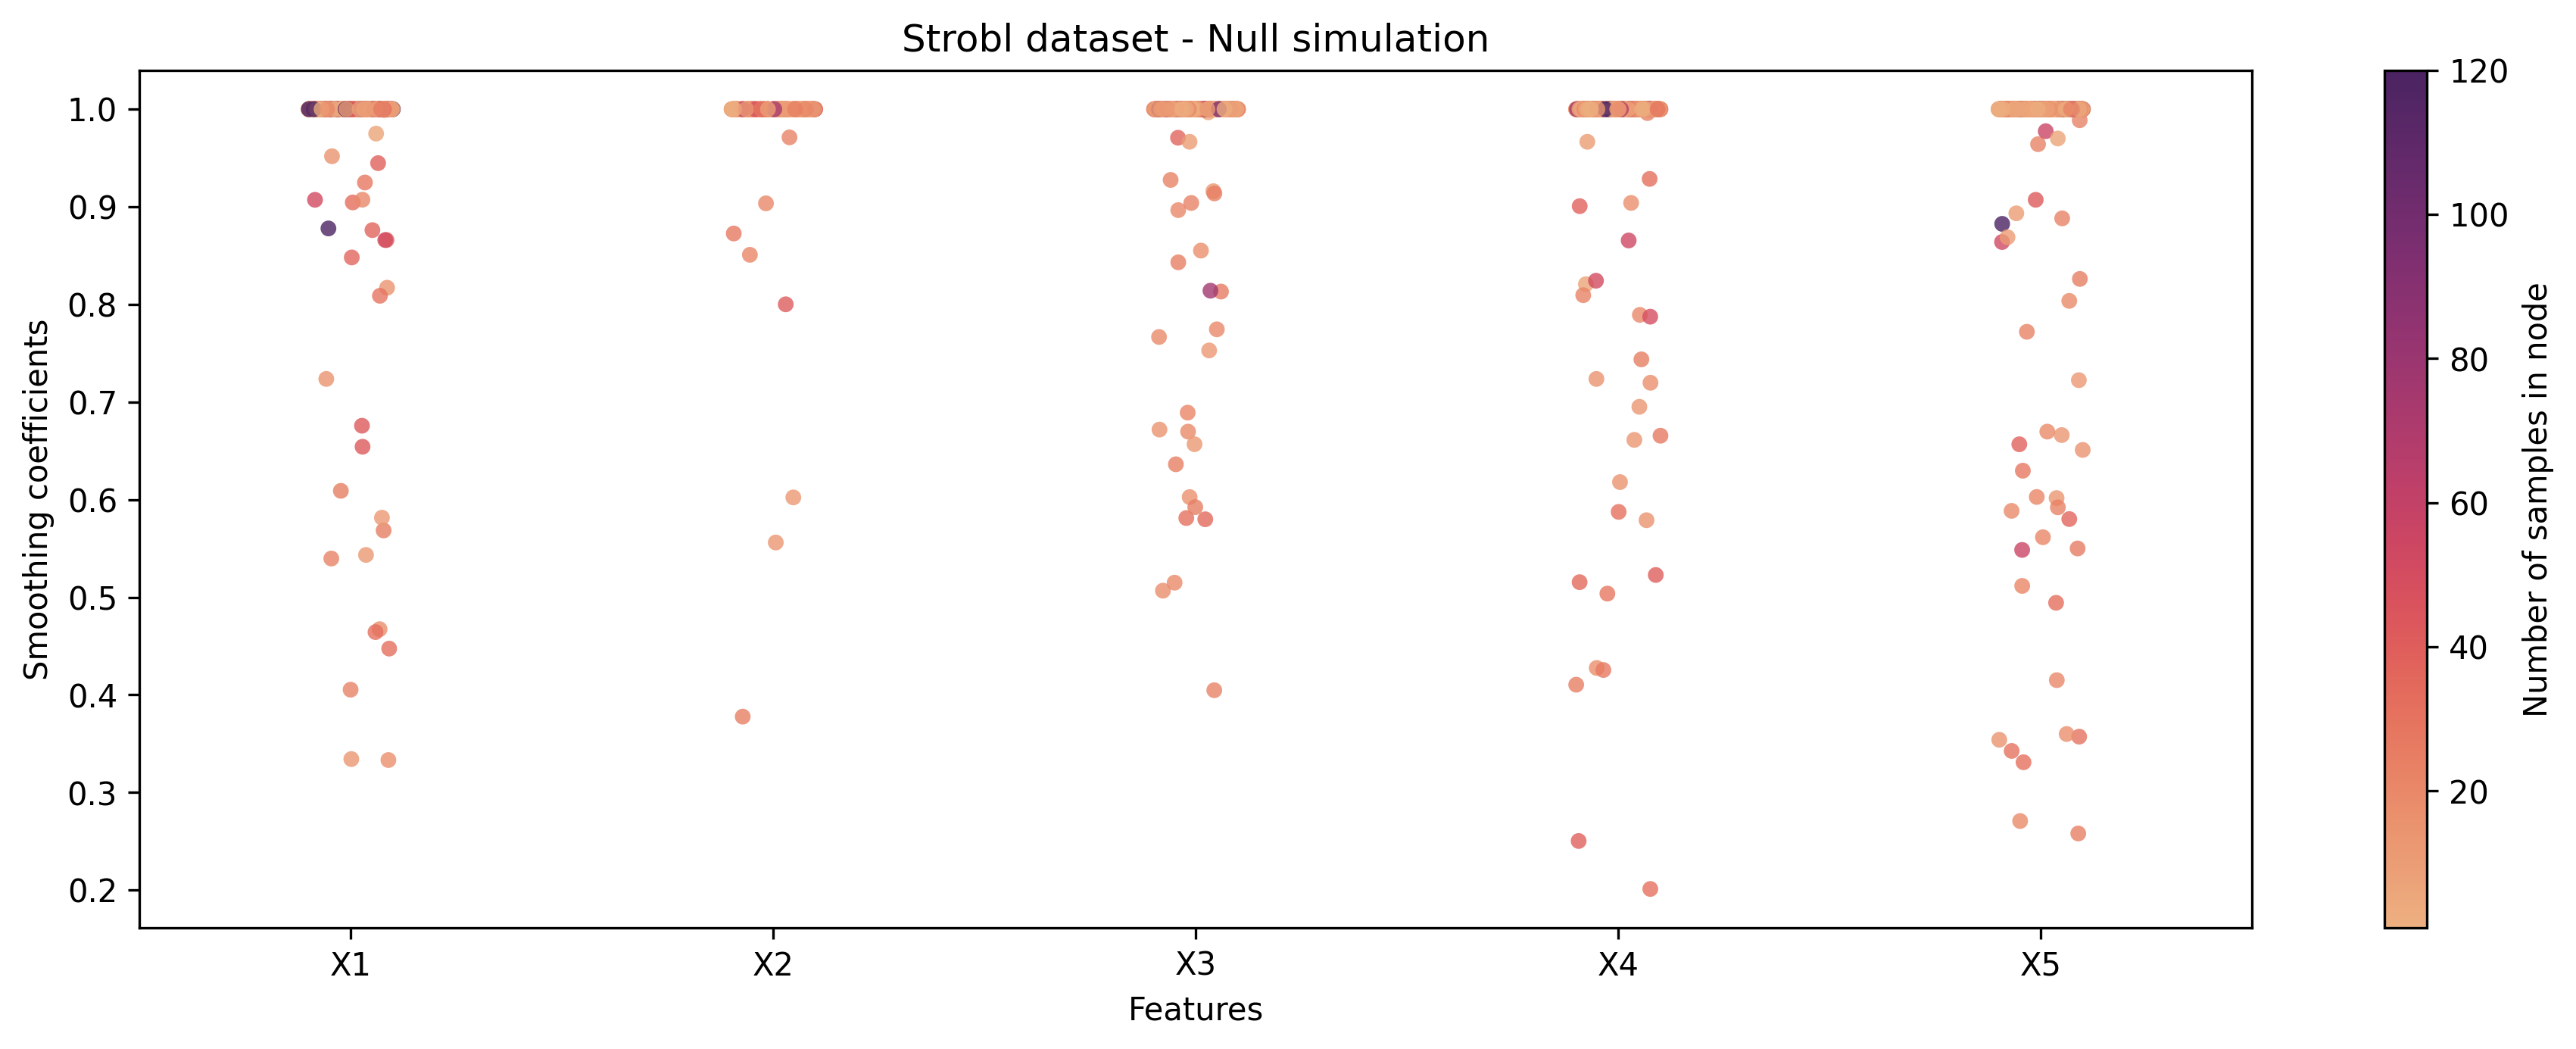

In [129]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=1, vmax=df_plot_null.samples.max()) 
palette = {h: cmap(norm(h)) for h in df_plot_null['samples']}

t = sns.stripplot(data=df_plot_null, x='child_feature', y='m_value', hue='samples', palette=palette, alpha=0.8, ax=axs, order=[0,1,2,3,4])
t.legend_.remove()  # remove the categorical legend

axs.set_xticklabels([f"X{i}" for i in range(1,6)])
axs.set_title(f"Strobl dataset - Null simulation")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Number of samples in node")  # optionally add a colorbar
plt.show()

In [130]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_smoothing_coefs")
filename = "strobl_null_MSEratio_coef_dist_plot_sample_size"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

#### Power case

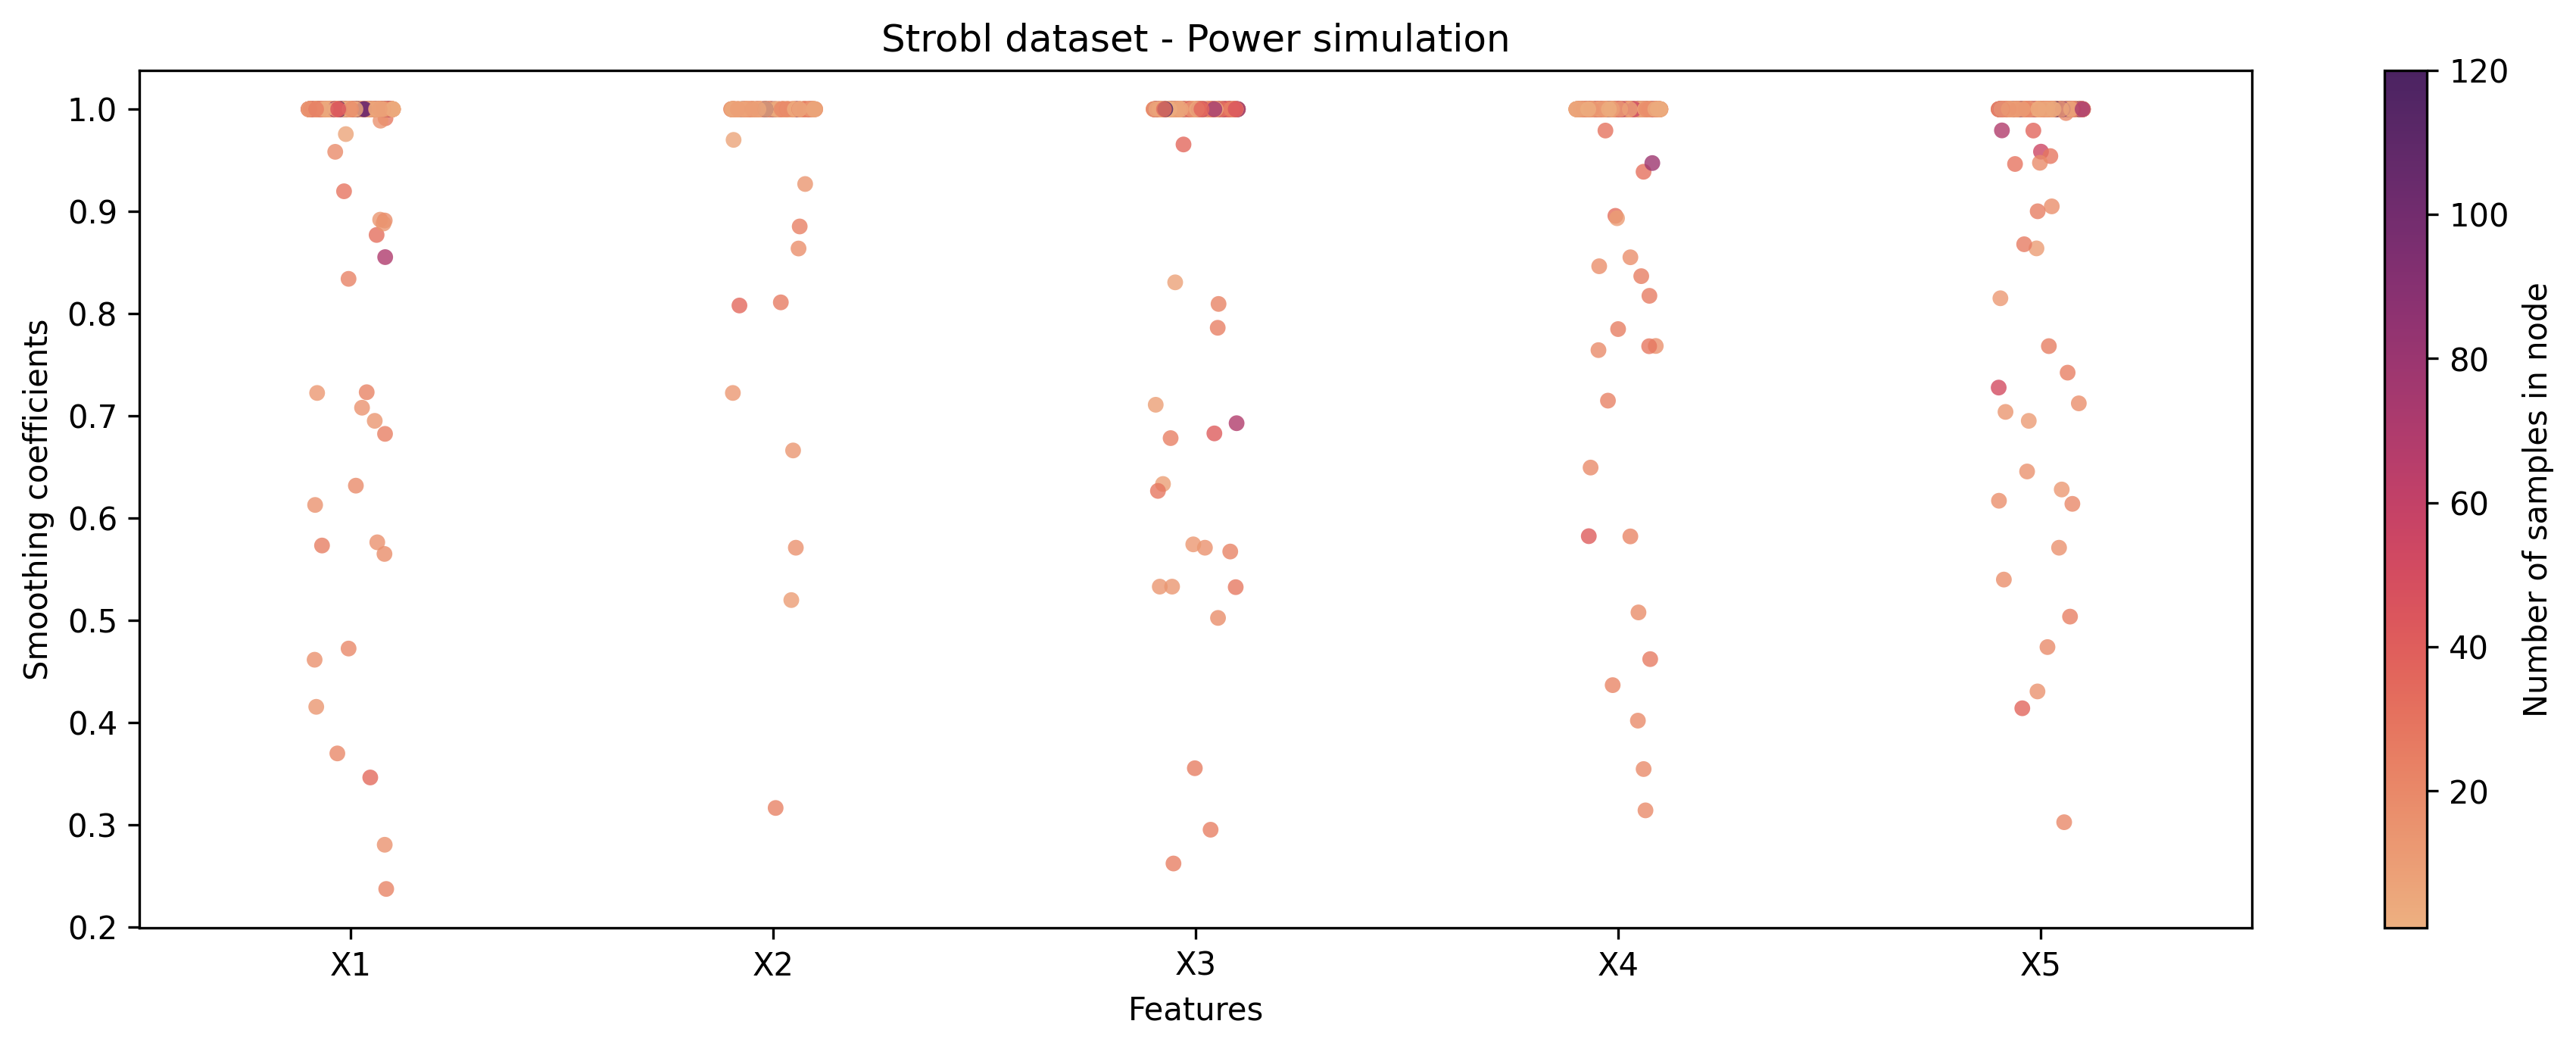

In [131]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=1, vmax=df_plot_power.samples.max()) 
palette = {h: cmap(norm(h)) for h in df_plot_power['samples']}

t = sns.stripplot(data=df_plot_power, x='child_feature', y='m_value', hue='samples', palette=palette, alpha=0.8, ax=axs, order=[0,1,2,3,4])
t.legend_.remove()  # remove the categorical legend

axs.set_xticklabels([f"X{i}" for i in range(1,6)])
axs.set_title(f"Strobl dataset - Power simulation")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Number of samples in node")  # optionally add a colorbar
plt.show()

In [132]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_smoothing_coefs")
filename = "strobl_power_MSEratio_coef_dist_plot_sample_size"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

### Create plot based on node depth in tree

#### Null case

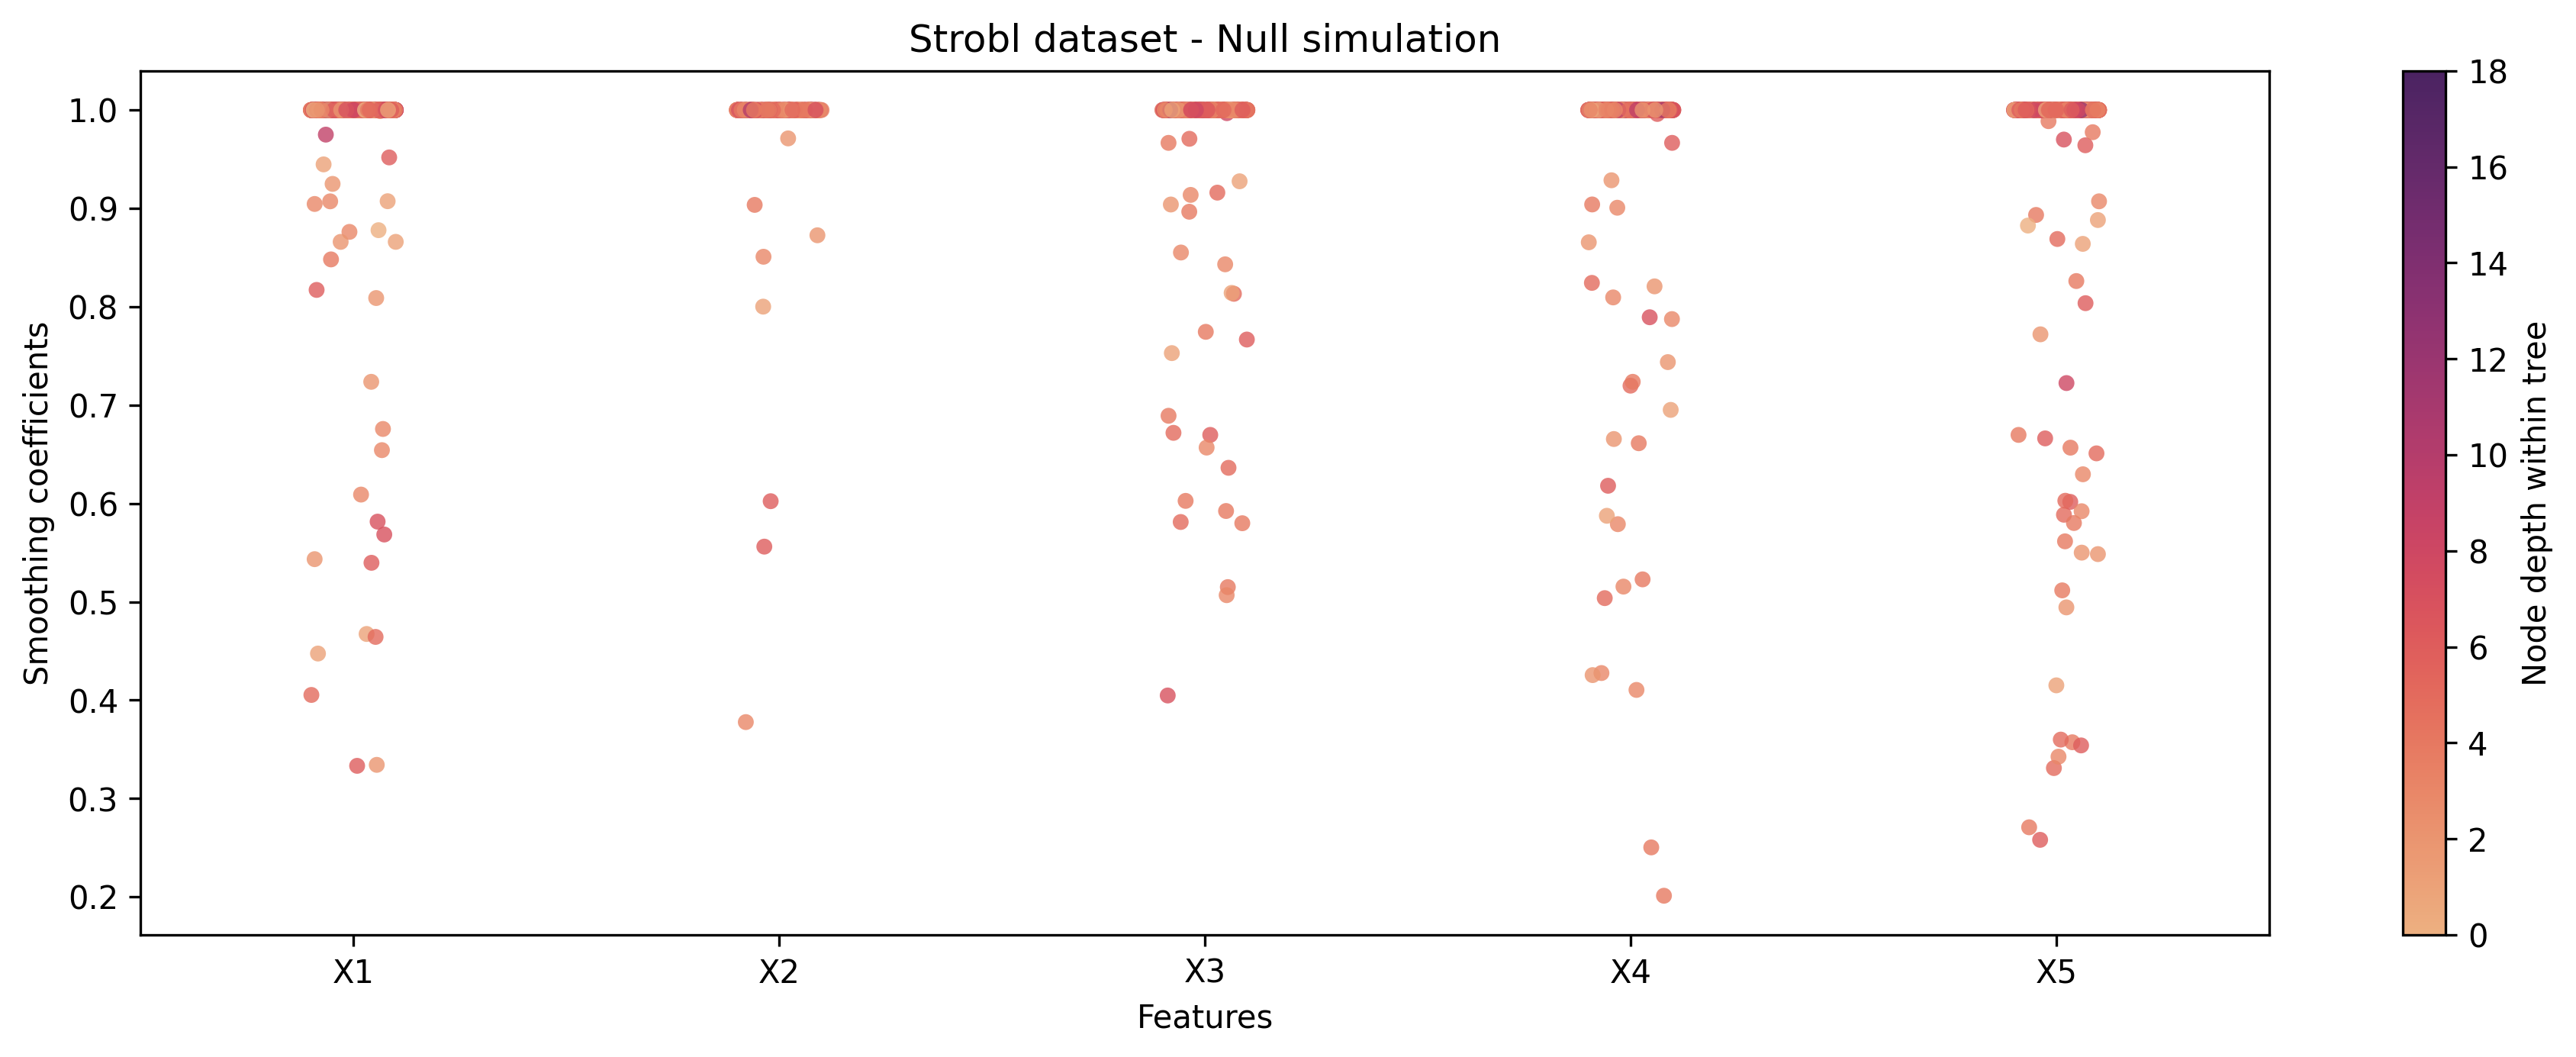

In [133]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=0, vmax=df_plot_null.node_depth.max()) 
palette = {h: cmap(norm(h)) for h in df_plot_null['node_depth']}

t = sns.stripplot(data=df_plot_null, x='child_feature', y='m_value', hue='node_depth', alpha=0.8, palette=palette, ax=axs, order=[0,1,2,3,4])
t.legend_.remove()  # remove the categorical legend

axs.set_xticklabels([f"X{i}" for i in range(1,6)])
axs.set_title(f"Strobl dataset - Null simulation")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Node depth within tree")  # optionally add a colorbar
plt.show()

Surprinsingly it seems that the shallower nodes show more shrinkage than deeper nodes ? 

In [134]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_smoothing_coefs")
filename = "strobl_null_MSEratio_coef_dist_plot_node_depth"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

#### Power case

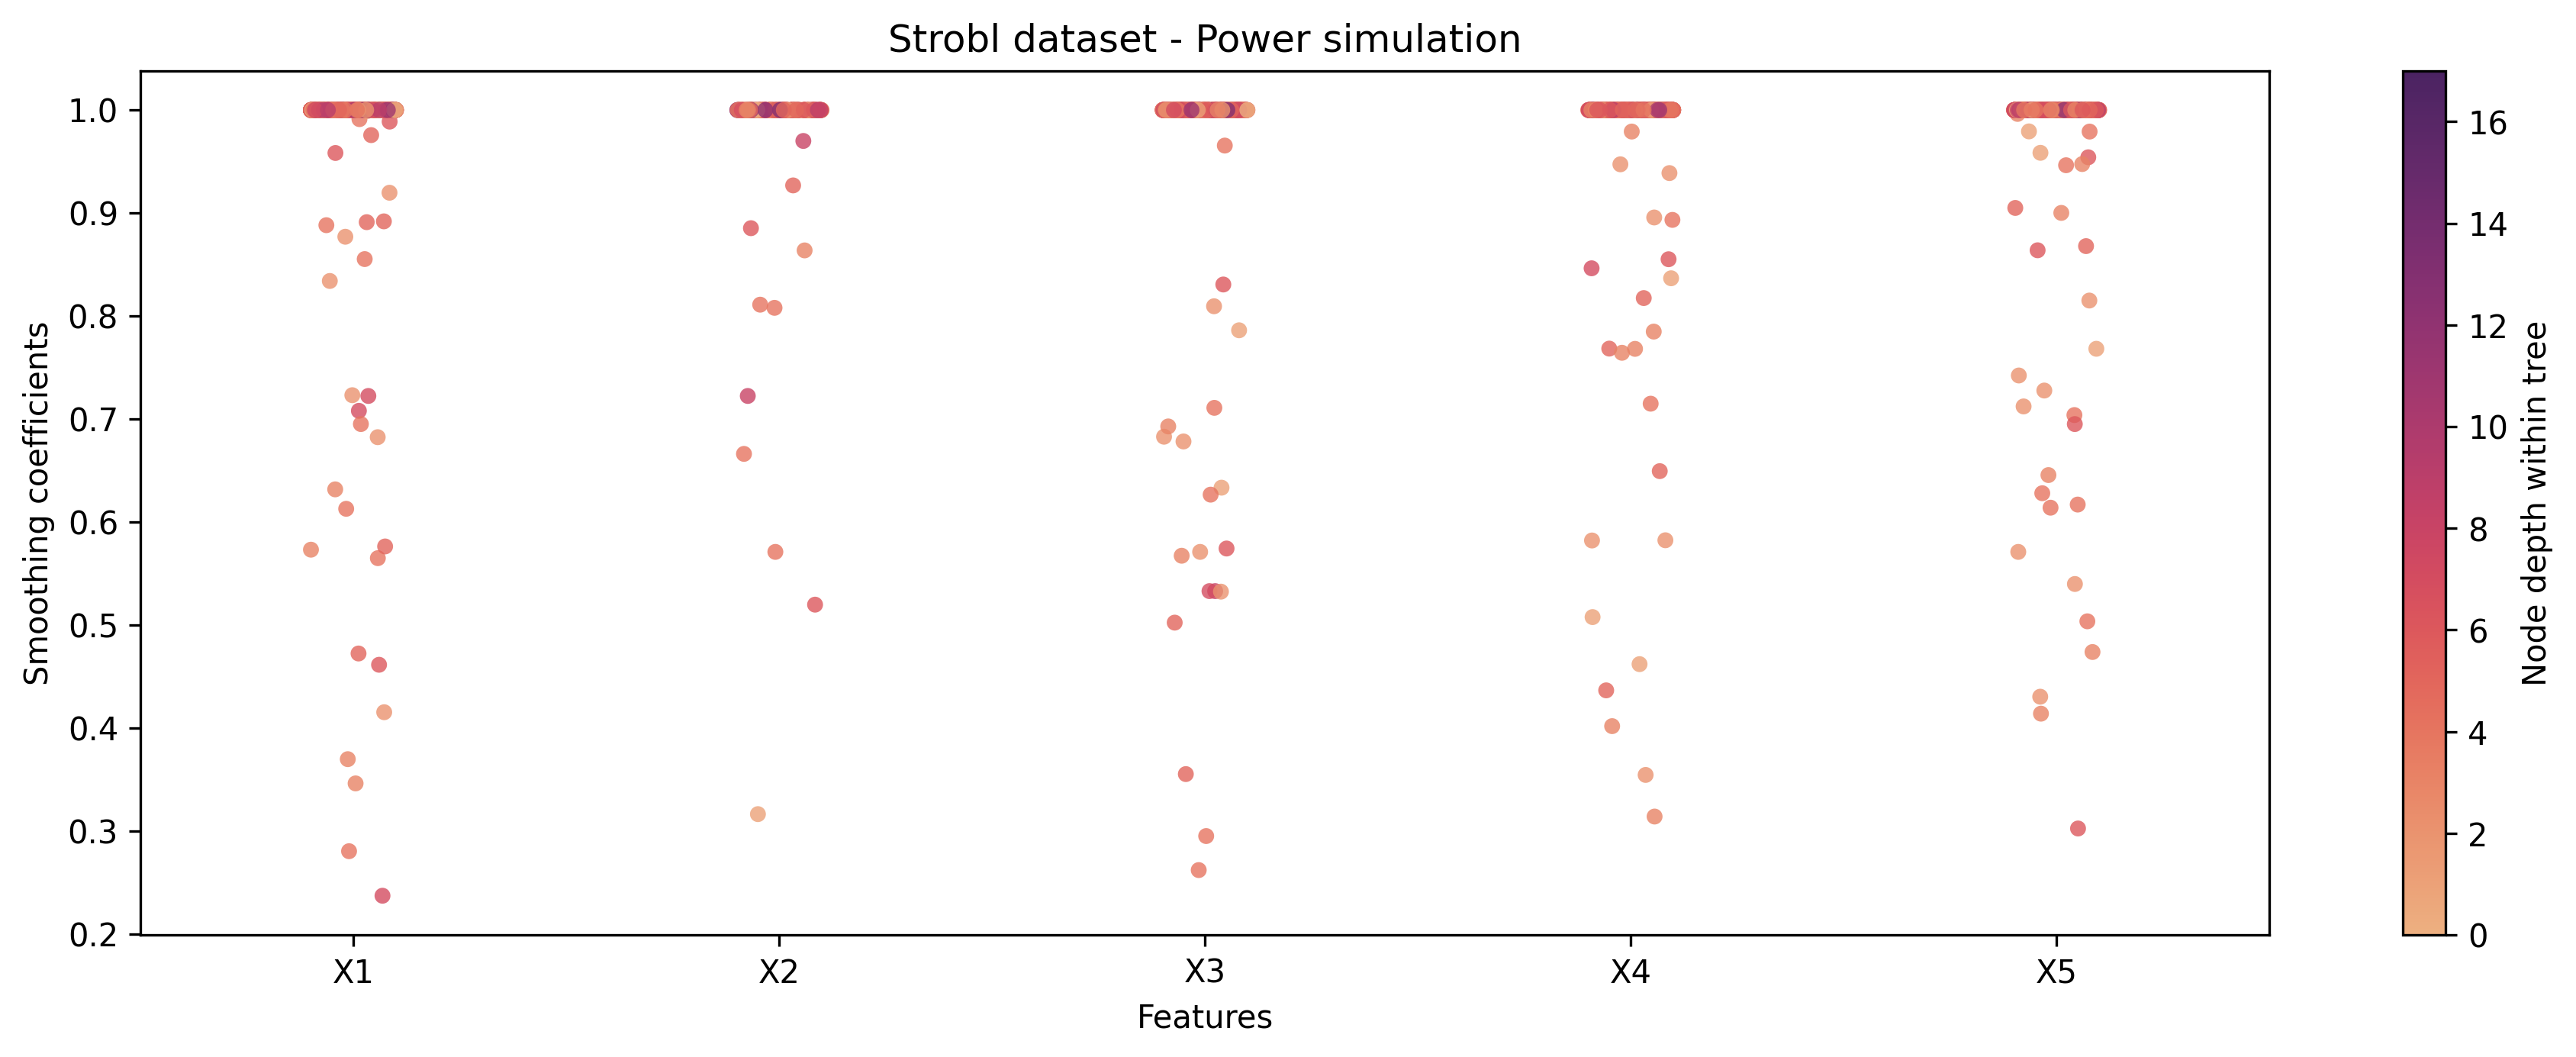

In [135]:
# since there are so many nodes we have to use stripplot instead of swarmplot
fig, axs = plt.subplots(1,1,figsize=(15,5))

cmap = sns.color_palette('flare', as_cmap=True)
norm = plt.Normalize(vmin=0, vmax=df_plot_power.node_depth.max()) 
palette = {h: cmap(norm(h)) for h in df_plot_power['node_depth']}

t = sns.stripplot(data=df_plot_power, x='child_feature', y='m_value', hue='node_depth', alpha=0.8, palette=palette, ax=axs, order=[0,1,2,3,4])
t.legend_.remove()  # remove the categorical legend

axs.set_xticklabels([f"X{i}" for i in range(1,6)])
axs.set_title(f"Strobl dataset - Power simulation")
axs.set_xlabel("Features")
axs.set_ylabel("Smoothing coefficients")
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=axs, label="Node depth within tree")  # optionally add a colorbar
plt.show()

Surprinsingly it seems that the shallower nodes show more shrinkage than deeper nodes ? 

In [136]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_smoothing_coefs")
filename = "strobl_null_MSEratio_coef_dist_plot_node_depth"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

# Smooth SHAP Shrinkage

## Strobl

Since we only get one coefficient p. feature for Smooth SHAP we will fit 10 models on 10 different datasets

In [170]:
#Null simulation
X_nulls, y_nulls = simulate_data_strobl(n=120, M=100, relevance=0, seed=42)
#Power simulation
X_powers, y_powers = simulate_data_strobl(n=120, M=100, relevance=0.15, seed=42)

Again we set lambda based on previous gridsearch results

In [171]:
# Fit models and store in list
null_models=[]
power_models=[]

for i in trange(10):
    null_rfsmSH = RandomForest(n_trees=100, HS_lambda=100, treetype="classification", oob=True, oob_SHAP=True, HS_smSHAP=True, random_state=42)
    null_rfsmSH.fit(X_nulls[i,:,:], y_nulls[:,i])
    null_models.append(null_rfsmSH)

    power_rfsmSH = RandomForest(n_trees=100, HS_lambda=1, treetype="classification", oob=True, oob_SHAP=True, HS_smSHAP=True, random_state=42)
    power_rfsmSH.fit(X_powers[i,:,:], y_powers[:,i])
    power_models.append(power_rfsmSH)

100%|██████████| 100/100 [04:55<00:00,  2.96s/it]


In [176]:
#Store smooth SHAP coefs
null_smSHAP_coefs = []
for model in null_models:
    null_smSHAP_coefs.append(np.abs(model.smSHAP_coefs))
    
power_smSHAP_coefs = []
for model in power_models:
    power_smSHAP_coefs.append(np.abs(model.smSHAP_coefs))

In [177]:
feat_names = ["x1","x2","x3","x4","x5"]
null_df = pd.DataFrame(null_smSHAP_coefs, columns=feat_names).melt()
power_df = pd.DataFrame(power_smSHAP_coefs, columns=feat_names).melt()

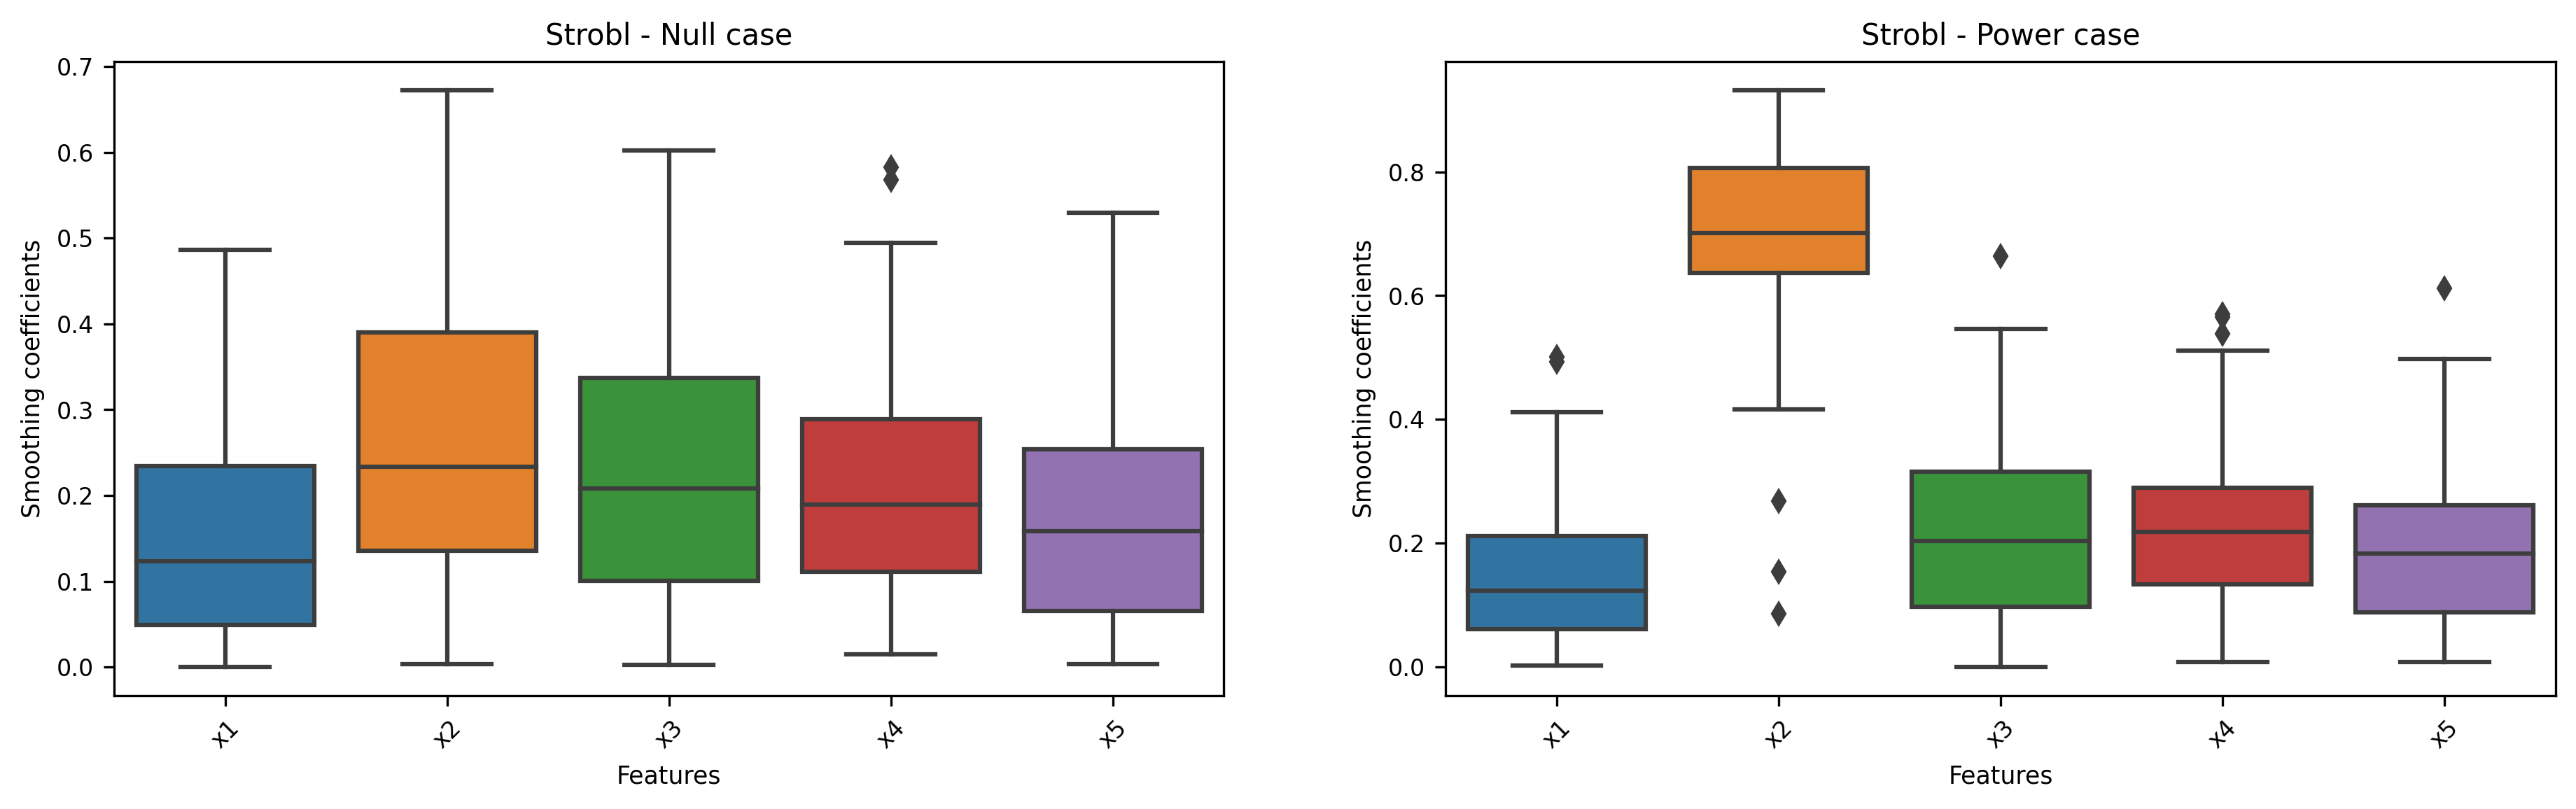

In [213]:
# Draw a nested boxplot to show abs shap values per feature and experiment
fig, axs = plt.subplots(1,2,figsize=(15,4))

n = sns.boxplot(x="variable", y="value", data=null_df, ax=axs[0])
p = sns.boxplot(x="variable", y="value", data=power_df, ax=axs[1])

for i, ax in enumerate(fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    if i==0:
        ax.set_title(f"Strobl - Null case", fontsize="medium")
    else:
        ax.set_title(f"Strobl - Power case", fontsize="medium")
    ax.set_xlabel("Features", fontsize="small")
    ax.set_ylabel("Smoothing coefficients", fontsize="small")
    for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(8);


- Smoothing coefficients even for informative features do not reach 1.
- Smoothing coefficients even for uninformative features do not reach 0.

In [214]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_smoothing_coefs")
filename = "strobl_null_smSH_coef_dist_plot"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)

#### Analyze slope of Smooth SHAP p. feature for one model

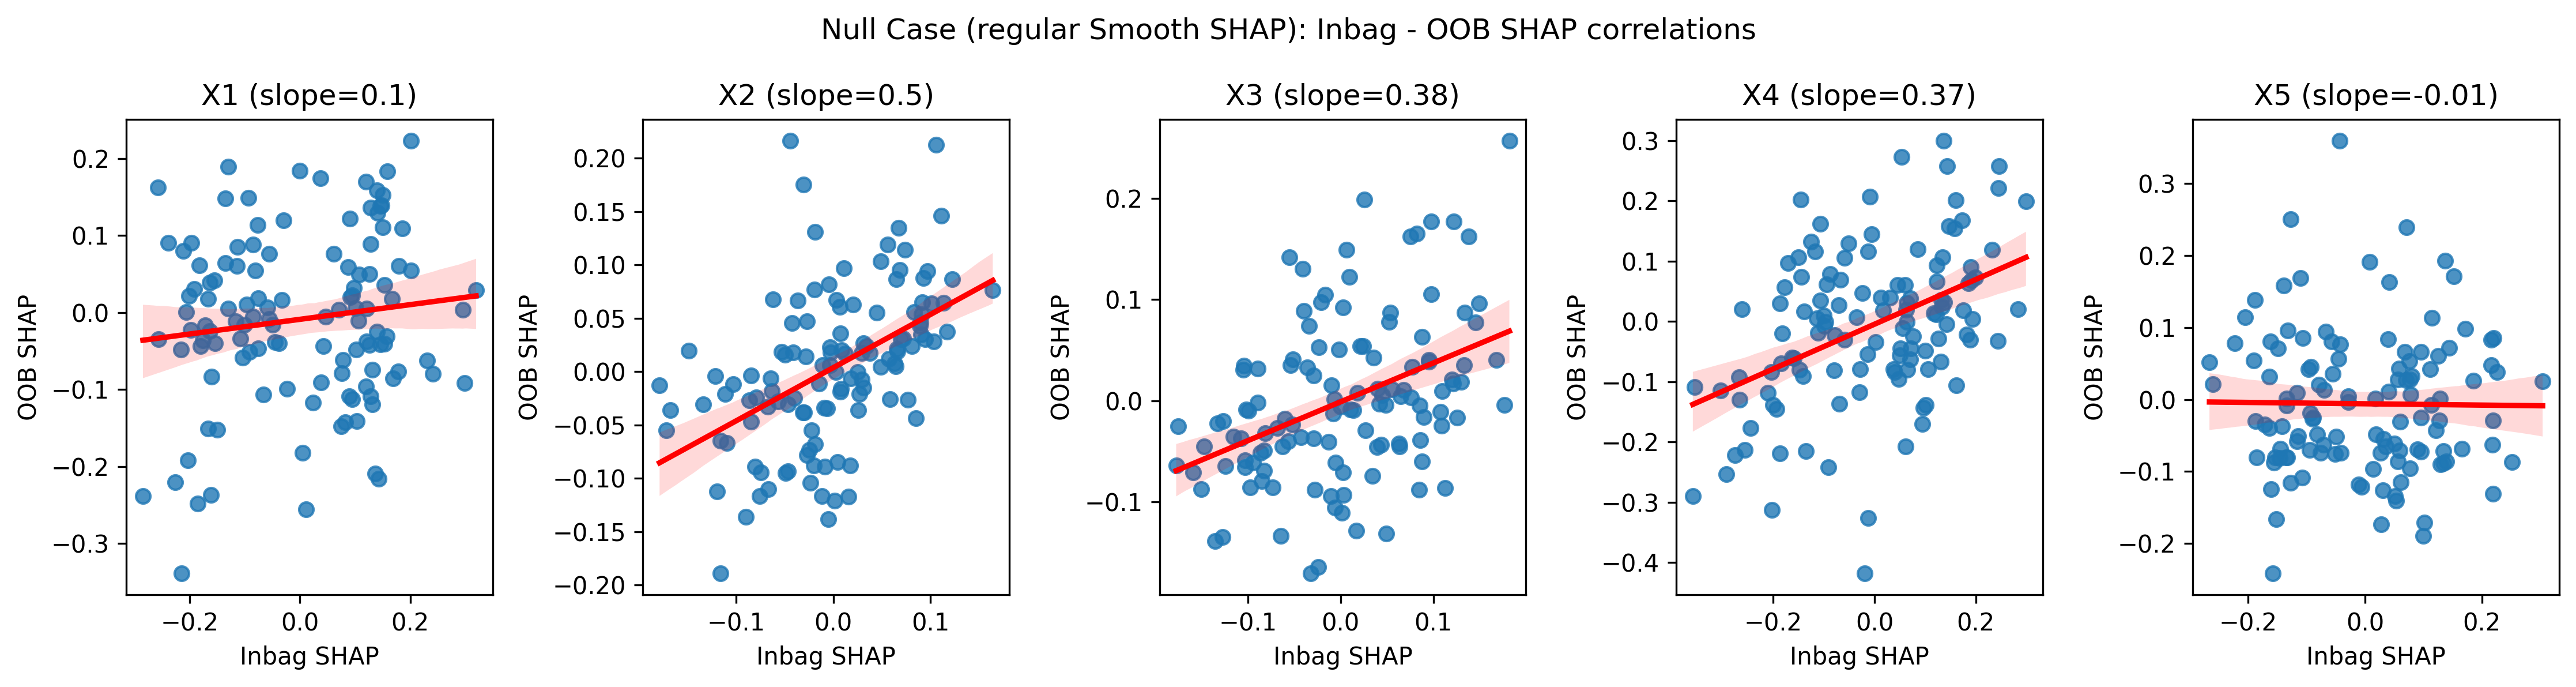

In [196]:
from scipy.stats import linregress
fig, axs = plt.subplots(1,5, figsize=(15,4))

for i in range(5):
    p = sns.regplot(x=null_models[0].inbag_SHAP_values[:, i].reshape(-1, 1), y=null_models[0].oob_SHAP_values[:, i], line_kws={"color": "red"}, ax=axs[i])
    slope, intercept, r_value, p_value, std_err = linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
    axs[i].set_title(f"X{i+1} (slope={round(slope,2)})")# - regression coef: {np.round(rf_scr.smSHAP_coefs[i],2)}")
    axs[i].set_xlabel("Inbag SHAP")
    axs[i].set_ylabel("OOB SHAP")

#plt.setp(axs, xlim=[0, 0.5], ylim=[0, 0.5]);
fig.suptitle("Null Case (regular Smooth SHAP): Inbag - OOB SHAP correlations")
plt.tight_layout();

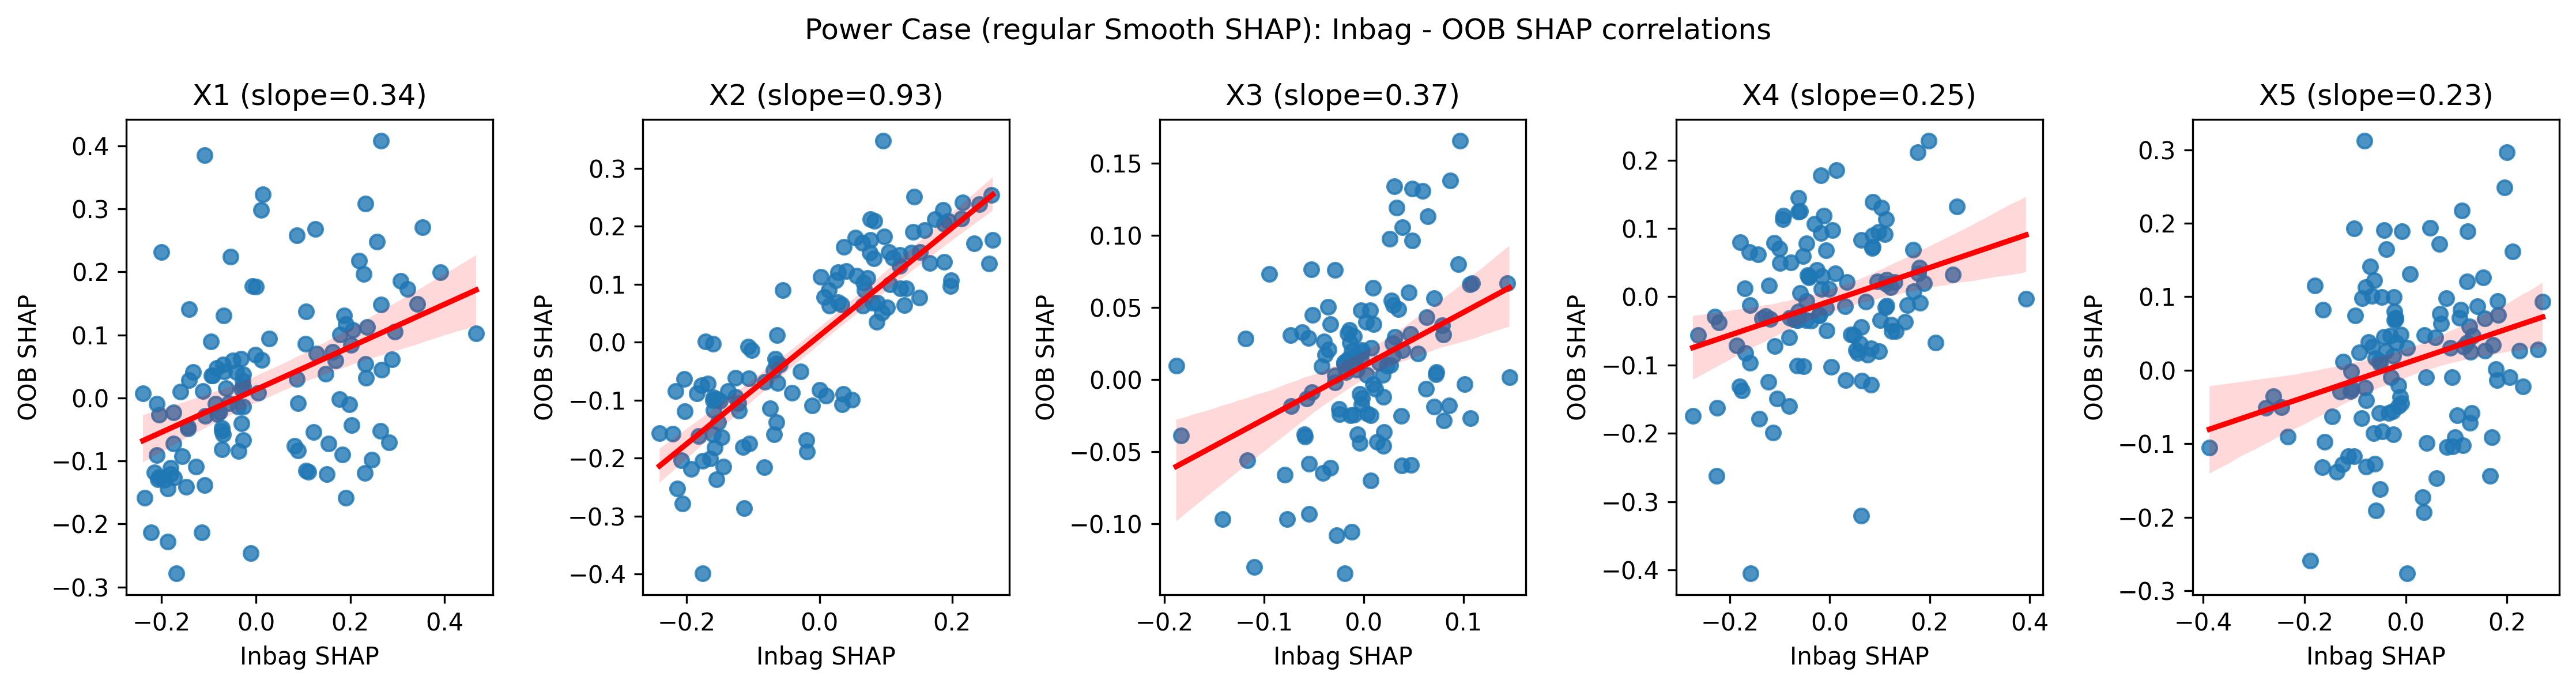

In [197]:
fig, axs = plt.subplots(1,5, figsize=(15,4))

for i in range(5):
    p = sns.regplot(x=power_models[0].inbag_SHAP_values[:, i].reshape(-1, 1), y=power_models[0].oob_SHAP_values[:, i], line_kws={"color": "red"}, ax=axs[i])
    slope, intercept, r_value, p_value, std_err = linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
    axs[i].set_title(f"X{i+1} (slope={round(slope,2)})")# - regression coef: {np.round(rf_scr.smSHAP_coefs[i],2)}")
    axs[i].set_xlabel("Inbag SHAP")
    axs[i].set_ylabel("OOB SHAP")

#plt.setp(axs, xlim=[0, 0.5], ylim=[0, 0.5]);
fig.suptitle("Power Case (regular Smooth SHAP): Inbag - OOB SHAP correlations")
plt.tight_layout();

## Titanic

In [199]:
#Load and clean data
data = pd.read_csv("../raw_data/titanic/titanic_train.csv")
data = data[data["Age"].notnull()] #filter rows which are nan
data["Sex"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)
X_titanic = data[['Age', 'Pclass', 'Sex', 'PassengerId']]
y_titanic = data["Survived"].astype("float")

We will run a 25 fold cross validation and store the smooth SHAP coefficients for each fold

In [203]:
# Fit models and store in list
from sklearn.model_selection import KFold

smSHAP_titanic_models=[]

kf = KFold(n_splits=25, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X_titanic):
    
    #split data
    X_train, X_test = X_titanic.iloc[train_index], X_titanic.iloc[test_index]
    y_train, y_test = y_titanic.iloc[train_index], y_titanic.iloc[test_index]

    #fit estimator
    rf_titanic_smSH = RandomForest(n_trees=25, HS_lambda=1, treetype="classification", oob=True, oob_SHAP=True, HS_smSHAP=True)     
    rf_titanic_smSH.fit(X_train, y_train)
    smSHAP_titanic_models.append(rf_titanic_smSH)

In [204]:
#Store smooth SHAP coefs
titanic_smSHAP_coefs = []
for model in smSHAP_titanic_models:
    titanic_smSHAP_coefs.append(np.abs(model.smSHAP_coefs))

In [205]:
feat_names = ['Age', 'Pclass', 'Sex', 'PassengerId']
titanic_df_smSH = pd.DataFrame(titanic_smSHAP_coefs, columns=feat_names).melt()

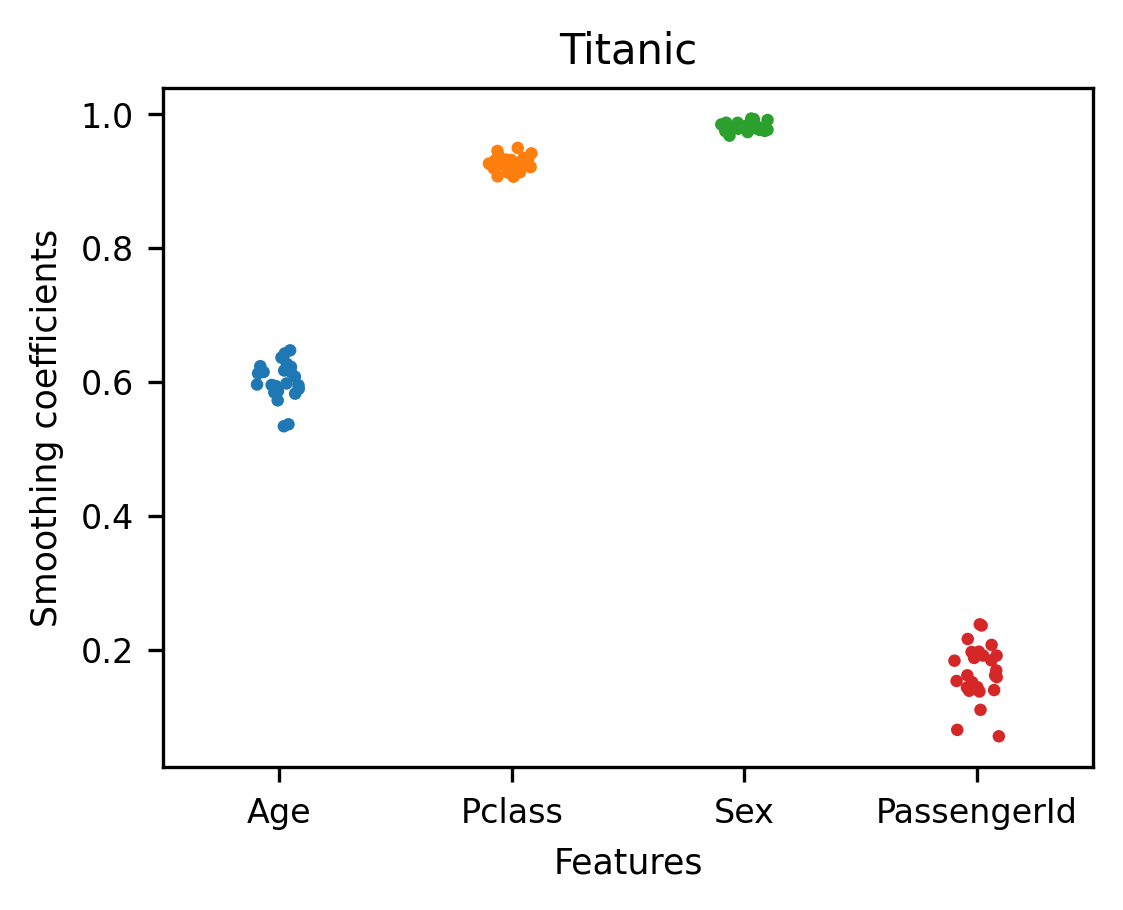

In [211]:
# Draw a nested boxplot to show abs shap values per feature and experiment
fig, ax = plt.subplots(1,1,figsize=(4,3))

n = sns.stripplot(x="variable", y="value", data=titanic_df_smSH, ax=ax, size=3)

ax.set_title(f"Titanic", fontsize="medium")
ax.set_xlabel("Features", fontsize="small")
ax.set_ylabel("Smoothing coefficients", fontsize="small")
for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(8);


In [212]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data", "dis_smoothing_coefs")
filename = "titanic_smSH_coef_dist_plot"

#save figure 
filename = f"{data_path}/{filename}.png"
fig.savefig(filename)